# Project : INTRODUCTION TO MACHINE LEARNING

## Imports

In [2]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import math 
import random 
import matplotlib.pyplot as plt 
import time 

## Chargement des données

In [3]:
dataset = pd.read_csv("waveform.data.csv", sep=',', header=None)

dataset_shuffle = dataset.sample(frac=1.0, random_state=42)

X = dataset_shuffle.iloc[:, :-1]
y = dataset_shuffle.iloc[:, -1]


## k-NN

In [4]:

X_train = X.iloc[:4000]
y_train = y.iloc[:4000]

X_test = X.iloc[4000:]
y_test = y.iloc[4000:]

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


In [20]:

def distance_euclidienne(point1, point2):
    """
    Calcule la distance euclidienne entre deux points.
    """
    somme_carres = 0.0
    for i in range(len(point1)):
        difference = point1[i] - point2[i]
        somme_carres += difference ** 2
    return somme_carres ** 0.5

def knn_algorithm(x, k, metrique, X_train, y_train):
    """
    Prédit la classe d'un point x en utilisant l'algorithme k-NN.
    """
    list_distances = []
    
    # Convertir x en tableau numpy 2D pour cdist
    x_2d = np.array(x).reshape(1, -1)
    
    for i in range(len(X_train)):
        # dist = distance_euclidienne(x, X_train.iloc[i].values)
        
        # Méthode 2 : Avec cdist (plus rapide)
        point_2d = np.array(X_train.iloc[i]).reshape(1, -1)
        dist = cdist(x_2d, point_2d, metric=metrique)[0][0]
        
        list_distances.append((dist, i))

    list_distances.sort(key=lambda x: x[0])  # Trie par distance

    k_nearest_neighbors = list_distances[:k]
    votes = {}
    
    for dist, index in k_nearest_neighbors:
        label = y_train.iloc[index]
        votes[label] = votes.get(label,0) + 1

    return max(votes, key=votes.get)


""" Optimisation KNN en vectorisant nos données et en effectuant les 4 millions de calculs de distance en seulement une opération avec Numpy """

def knn_algorithm_vectorise(x, k, metrique, X_train, y_train):
    x_2d = np.array(x).reshape(1, -1)
    X_2d = np.array(X_train)
    
    distances = cdist(x_2d, X_2d, metric=metrique)[0]
    
    k_indices = np.argsort(distances)[:k]
    votes = y_train.iloc[k_indices].value_counts()
    return votes.idxmax()

def evaluer_modele(X_test, y_test, k, metrique, X_train, y_train):
    """
    Évalue la performance du modèle kNN sur un ensemble de test
    """
    nombre_correct = 0
    total = len(X_test)
    
    for i in range(total):
        point_test = X_test.iloc[i].values  # Convertir en numpy array
        vrai_label = y_test.iloc[i]
        
        # prediction = knn_algorithm(point_test, k, metrique, X_train, y_train)
        prediction = knn_algorithm_vectorise(point_test, k, metrique, X_train, y_train)
        if prediction == vrai_label.item():
            nombre_correct += 1
    
    return nombre_correct / total

def cross_validation_knn(X, y, k_values, n_folds=5, metric='euclidean'):
    """
    Cross-validation pour choisir le meilleur k

    Args:
        X: Features du dataset
        y: Labels du dataset complet
        k_values: Liste contenant les valeurs de k à tester
        n_folds: Nombre de folds
        metric: Métrique de distance

    Returns:
        best_k: Meilleure valeur de k
        best_accuracy: Meilleure précision moyenne
        results: Dictionnaire avec les résultats pour chaque k
    """
    
    results = {k: [] for k in k_values}
    
    # création des folds
    fold_size = len(X) // n_folds
    indices = np.arange(len(X))
    
    # mélanger les indices pour des folds aléatoires
    np.random.shuffle(indices)
    
    print(f"Début de la cross-validation ({n_folds} folds) pour les k: {k_values}")
    
    # Pour chaque fold
    for fold in range(n_folds):
        print(f"fold {fold + 1}/{n_folds}...")
        
        # Définition des indices pour validation et entraînement
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size
        val_indices = indices[val_start:val_end]
        train_indices = np.concatenate([indices[:val_start], indices[val_end:]])
        
        # créer des datasets pour ce fold
        X_train_fold = X.iloc[train_indices].reset_index(drop=True)
        y_train_fold = y.iloc[train_indices].reset_index(drop=True)
        X_val_fold = X.iloc[val_indices].reset_index(drop=True)
        y_val_fold = y.iloc[val_indices].reset_index(drop=True)
        
        # evaluation pour chaque valeur de k
        for k in k_values:
            accuracy = evaluer_modele(X_val_fold, y_val_fold, k, metric, X_train_fold, y_train_fold)
            results[k].append(accuracy)
    
    # calcul des moyennes et choix du meilleur k
    best_accuracy = 0
    best_k = None
    mean_accuracies = {}
    
    for k in k_values:
        mean_accuracy = np.mean(results[k])
        mean_accuracies[k] = mean_accuracy
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_k = k
    
    return best_k, best_accuracy, mean_accuracies
    

# Utilisation
def plot_results(mean_accuracies):
    """Trace les résultats de la cross-validation"""
    import matplotlib.pyplot as plt
    
    k_values = list(mean_accuracies.keys())
    accuracies = list(mean_accuracies.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracies, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Valeur de k')
    plt.ylabel('Accuracy moyenne')
    plt.title('Performance du kNN en fonction de k (Cross-Validation)')
    plt.grid(True, alpha=0.3)
    plt.xticks(k_values)
    
    # marquer en rouge le meilleur k
    best_k = max(mean_accuracies, key=mean_accuracies.get)
    best_acc = mean_accuracies[best_k]
    min_k = min(mean_accuracies, key=mean_accuracies.get)
    min_acc = mean_accuracies[min_k]
    plt.plot(best_k, best_acc, 'ro', markersize=10, label=f'Meilleur k: {best_k} ({best_acc:.3f})')
    plt.plot([k_values[0], best_k], [best_acc, best_acc], "r:")
    plt.plot([best_k, best_k], [min_acc, best_acc], "r:")
    plt.legend()
    
    plt.show()


### Execution

~ 2-4 minutes

In [21]:
def main_knn():
    # utilise seulement les 4000 points d'entraînement pour la CV
    k_values = list(range(1, 51))
    
    best_k, best_accuracy, mean_accuracies = cross_validation_knn(
        X_train, y_train, k_values, n_folds=5, metric='euclidean'
    )
    
    print(f"\n Meilleur k: {best_k}, précision de {best_accuracy:.4f}")
    
    plot_results(mean_accuracies)
    
    # test set avec le meilleur k
    final_accuracy = evaluer_modele(X_test, y_test, best_k, 'euclidean', X_train, y_train)
    print(f"Accuracy finale sur le test set: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)" + " avec k k={best_k}")
    print(f"Bayes optimal: 86%")


Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 48, précision de 0.8565


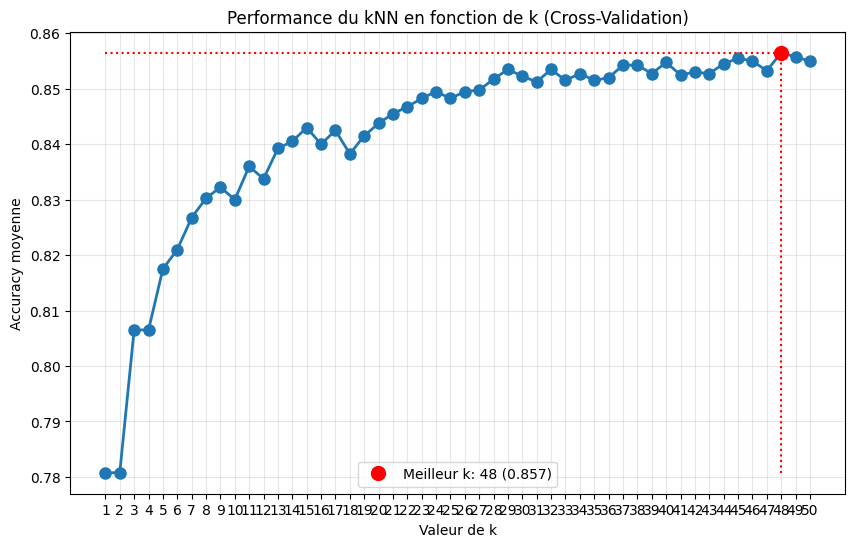

Accuracy finale sur le test set: 0.8590 (85.90%) avec k k={best_k}
Bayes optimal: 86%


In [53]:
main_knn()

### Test

In [8]:
# Test
accuracy = evaluer_modele(X_test, y_test, 5, 'euclidean', X_train, y_train)
print(f"Avec k=5, accuracy = {accuracy:.3f} ({accuracy*100:.1f}%)")

Avec k=5, accuracy = 0.823 (82.3%)


## Data reduction

In [124]:
def distance(v1,v2):
    """
    Renvoie la distance euclidiennes entre les vecteurs v1 et v2
    """
    somme = 0. 
    for x, y in zip(v1, v2):
        somme += (x - y) ** 2
    return math.sqrt(somme)

def un_NN(p, X, y): # TODO à optimiser en se servant des distances déjà calculées pour le k-NN 
    """
    1-NN 

    Args:
        p: Point à tester
        X: Features du dataset
        y: Labels du dataset 

    Returns:
        label: label du point le plus proche 
    """

    # Initialisation 
    # dmin = distance(p, X[0])
    dmin = cdist(p.reshape(1, -1), X[0].reshape(1, -1), metric="euclidean")[0][0]
    label = y[0]

    for i in range(1, X.shape[0]):
        #d = distance(p, X[i])
        d = cdist(p.reshape(1, -1), X[i].reshape(1, -1), metric="euclidean")[0][0]
        if d < dmin: # si on trouve un point plus proche 
            dmin = d
            label = y[i]
    
    return label

def sep_data(X, y):
    """
    Mélange et sépare les données 

    Args:
        X: Features du dataset
        y: Labels du dataset 

    Returns:
        l_id: Liste d'indices 
        milieu: indice du milieu
    """
    l_id = [i for i in range(X.shape[0])]
    random.shuffle(l_id)
    milieu = len(l_id) // 2
    return (l_id, milieu)

def reduction1(X, y):
    """
    1ère algorithme de réduction du dataset vu en cours 
    Suppression de la zone de biais 
    
    Args:
        X: Features du dataset
        y: Labels du dataset 

    Returns:
        X_cleaned, y_cleaned: Dataset après réduction 
    """

    # Split randomly S into two subsets S1 and S2;
    (ordre, milieu) = sep_data(X, y)
    S1_X, S1_y = X[ordre[:milieu]], y[ordre[:milieu]]
    S2_X, S2_y = X[ordre[milieu:]], y[ordre[milieu:]]

    ch = True 
    while (ch): # Tant qu'il y a un changement S1 et S2 ne sont pas stabilisées 
        ch = False

        # Classify S1 with S2 using the 1-NN rule;
        # Remove from S1 the misclassified instances;
        nv_S1_X = []
        nv_S1_y = []
        for xi, yi in zip(S1_X, S1_y):
            l = un_NN(xi, S2_X, S2_y)
            if l == yi: 
                nv_S1_X.append(xi)
                nv_S1_y.append(yi)
            else:
                ch = True # pas encore stable car mal classé 
        S1_X = np.array(nv_S1_X)
        S1_y = np.array(nv_S1_y)

        # Classify S2 with the new set S1 using the 1-NN rule;
        # Remove from S2 the misclassified instances;
        nv_S2_X = []
        nv_S2_y = []
        for xi, yi in zip(S2_X, S2_y):
            l = un_NN(xi, S1_X, S1_y)
            if l == yi: 
                nv_S2_X.append(xi)
                nv_S2_y.append(yi)
            else:
                ch = True # pas encore stable car mal classé 
        S2_X = np.array(nv_S2_X)
        S2_y = np.array(nv_S2_y)
    
    # Union de S1 et S2 
    X_cleaned = np.concatenate((S1_X, S2_X), axis=0)
    y_cleaned = np.concatenate((S1_y, S2_y))
    
    return (X_cleaned, y_cleaned)

def reduction2(X, y):
    """
    2ème algorithme de réduction du dataset vu en cours 
    Suppression des données non pertinentes 
    
    Args:
        X: Features du dataset
        y: Labels du dataset 

    Returns:
        X_cleaned, y_cleaned: Dataset après réduction 
    """

    # Initialisation
    STORAGE_X = []
    STORAGE_y = []
    DUSTBIN_X = []
    DUSTBIN_y = []

    # Draw randomly a training example from S and put it in STORAGE;
    idx0 = random.randint(0, X.shape[0] - 1)
    STORAGE_X.append(X[idx0])
    STORAGE_y.append(y[idx0])

    ch = True
    while (ch): # Tant que STORAGE n'est pas stabilisé 
        ch = False
        
        for xi, yi in zip(X, y):

            # Ne pas traiter un point déjà dans STORAGE 
            liste_STORAGE_X = [p.tolist() for p in STORAGE_X]
            if xi.tolist() in liste_STORAGE_X:
                continue

            l = un_NN(xi, np.array(STORAGE_X), np.array(STORAGE_y))

            if l == yi: # if xi is correctly classified with STORAGE using the 1-NN rule
                # bien classé -> poubelle (inutile)
                DUSTBIN_X.append(xi)
                DUSTBIN_y.append(yi)
            else:
                # mal classé -> stockage (utile)
                STORAGE_X.append(xi)
                STORAGE_y.append(yi)
                ch = True

    return (np.array(STORAGE_X), np.array(STORAGE_y))


### PCA

In [15]:
def pca(X, y, titre):
    """
    PCA
    
    Args:
        X: Features du dataset
        y: Labels du dataset 
        titre : titre du graphe
    """

    X_pca = np.concatenate((X, y.reshape((y.shape[0], 1))), axis=1)

    labels = X_pca[:, -1].astype(int)
    X_features = X_pca[:, :-1]

    # Centrer les données (features)
    X_meaned = X_features - np.mean(X_features, axis=0)

    cov_mat = np.cov(X_meaned, rowvar=False)

    # Valeurs propres et vecteurs propres
    eigenvalues, eigenvectors = np.linalg.eigh(cov_mat)

    # Tri décroissant
    sorted_index = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_index]

    # Projection sur les 2 premiers vecteurs propres
    eigenvector_subset = sorted_eigenvectors[:, 0:2]
    X_reduced = np.dot(X_meaned, eigenvector_subset)

    # Affichage avec couleur par label
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_reduced[:,0], X_reduced[:,1], c=labels, cmap='viridis', edgecolor='k')

    # Ajouter une légende
    plt.legend(*scatter.legend_elements(), title="Labels")
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(titre)
    plt.grid(True)
    plt.show()

### Avant réduction 

In [24]:
# Les fonctions de réductions prennent des tableau numpy 
X_np = X.to_numpy()
y_np = y.to_numpy()

X_np_train = X_np[:4000, :]
y_np_train = y_np[:4000]

X_np_test = X_np[4000:, :]
y_np_test = y_np[4000:]

### 1ère réduction 

In [12]:
(X_train_cleaned, y_train_cleaned) = reduction1(X_np_train, y_np_train) 
print(X_np_train.shape, "-> X_cleaned :", X_train_cleaned.shape)

(4000, 21) -> X_cleaned : (3201, 21)


### 2ème réduction

In [13]:
(X_train_cleaned2, y_train_cleaned2) = reduction2(X_train_cleaned, y_train_cleaned)
print(X_train_cleaned.shape, "-> X_cleaned2 :", X_train_cleaned2.shape)

(3201, 21) -> X_cleaned2 : (707, 21)


## Affichage

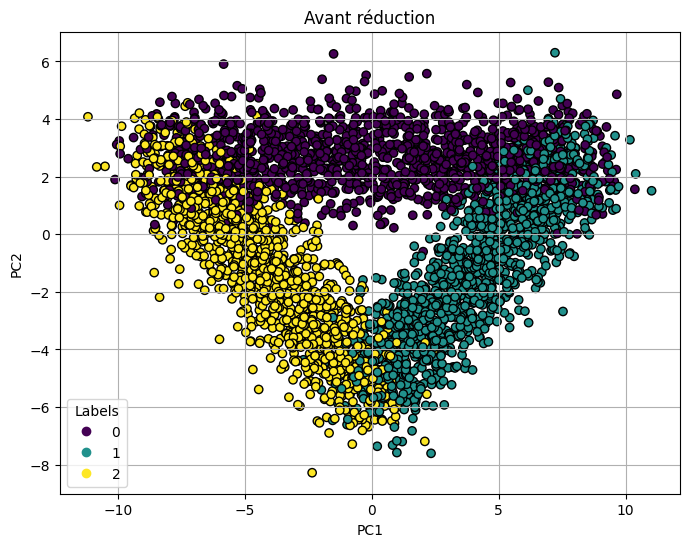

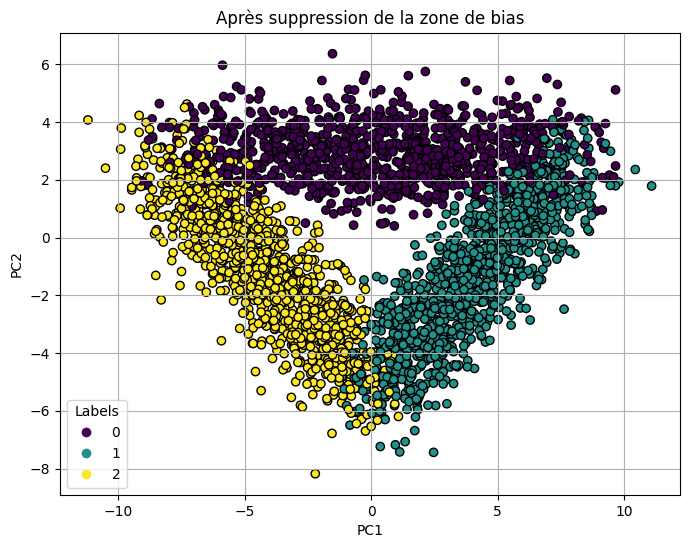

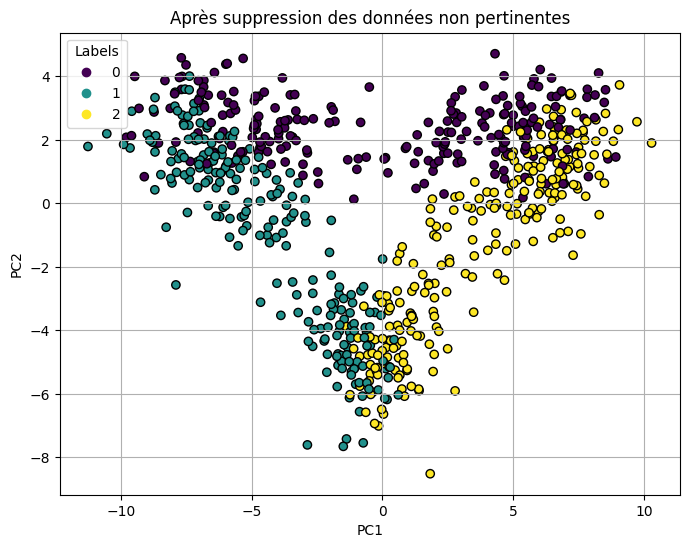

In [16]:
pca(X_np_train, y_np_train, "Avant réduction")
pca(X_train_cleaned, y_train_cleaned, "Après suppression de la zone de bias")
pca(X_train_cleaned2, y_train_cleaned2, "Après suppression des données non pertinentes")

## Lancement du k-NN après réduction des données 

In [46]:
X_train = X_train_cleaned2
y_train = y_train_cleaned2

X_test = X_np_test
y_test = y_np_test

X_train = pd.DataFrame(X_train).reset_index(drop=True)
y_train = pd.DataFrame(y_train).reset_index(drop=True)
X_test = pd.DataFrame(X_test).reset_index(drop=True)
y_test = pd.DataFrame(y_test).reset_index(drop=True)

main_knn()

NameError: name 'X_train_cleaned2' is not defined

## Avec distances précalculées

In [156]:

def knn_algorithm_vectorise(p_indice, k, indices_train, D, y_np):
    """
    Args:
        p_indice : indice du point (numpy)
        k : nb voisins
        indices_train : indices des données d'entraînement 
        D : matrices des distances 
    """

    distances = D[p_indice, indices_train]  # distances du point test aux points d'entraînement
    k_indices = np.argsort(distances)[:k]
    k_nearest = [indices_train[i] for i in k_indices]
    votes = y_np[k_nearest].astype(int)
    return np.bincount(votes).argmax()


def evaluer_modele(X_np, y_np, indices_test, k, indices_train, D):
    """
    Évalue la performance du modèle kNN sur un ensemble de test
    """
    nombre_correct = 0
    total = len(indices_test)
    
    for i in indices_test:
        vrai_label = y_np[i]
        
        prediction = knn_algorithm_vectorise(i, k, indices_train, D, y_np)
        if prediction == vrai_label:
            nombre_correct += 1
    
    return nombre_correct / total


def cross_validation_knn(X_np, y_np, k_values, n_folds=5):
    
    results = {k: [] for k in k_values}
    
    # création des folds
    fold_size = X_np.shape[0] // n_folds
    
    print(f"Début de la cross-validation ({n_folds} folds) pour les k: {k_values}")

    # Calcul de toutes les distances 
    D = cdist(X_np, X_np, metric='euclidean')
    
    # Pour chaque fold
    for fold in range(n_folds):
        print(f"fold {fold + 1}/{n_folds}")
        
        # Définition des indices pour validation et entraînement
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size
        indices_test = [i for i in range(val_start, val_end)]
        indices_train = [i for i in range(X_np.shape[0]) if i not in indices_test]
        
        # evaluation pour chaque valeur de k
        for k in k_values:
            accuracy = evaluer_modele(X_np, y_np, indices_test, k, indices_train, D)
            results[k].append(accuracy)
    
    # calcul des moyennes et choix du meilleur k
    best_accuracy = 0
    best_k = None
    mean_accuracies = {}
    
    for k in k_values:
        mean_accuracy = np.mean(results[k])
        mean_accuracies[k] = mean_accuracy
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_k = k
    
    return best_k, best_accuracy, mean_accuracies


def plot_results(mean_accuracies):
    """Trace les résultats de la cross-validation"""
    import matplotlib.pyplot as plt
    
    k_values = list(mean_accuracies.keys())
    accuracies = list(mean_accuracies.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracies, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Valeur de k')
    plt.ylabel('Accuracy moyenne')
    plt.title('Performance du kNN en fonction de k (Cross-Validation)')
    plt.grid(True, alpha=0.3)
    plt.xticks(k_values)
    
    # marquer en rouge le meilleur k
    best_k = max(mean_accuracies, key=mean_accuracies.get)
    best_acc = mean_accuracies[best_k]
    min_k = min(mean_accuracies, key=mean_accuracies.get)
    min_acc = mean_accuracies[min_k]
    plt.plot(best_k, best_acc, 'ro', markersize=10, label=f'Meilleur k: {best_k} ({best_acc:.3f})')
    plt.plot([k_values[0], best_k], [best_acc, best_acc], "r:")
    plt.plot([best_k, best_k], [min_acc, best_acc], "r:")
    plt.legend()
    
    plt.show()


def main_knn(X_np, y_np):
    # utilise seulement les 4000 points d'entraînement pour la CV
    k_values = list(range(1, 50 + 1))
    n = X_np.shape[0] * 4 // 5

    # Séparation des données
    indices_train = [i for i in range(n)]
    indices_test = [i for i in range(n, len(X))]

    X_train = X_np[:n]
    y_train = y_np[:n]
    
    best_k, best_accuracy, mean_accuracies = cross_validation_knn(
        X_train, y_train, k_values, n_folds=5
    )
    
    print(f"\n Meilleur k: {best_k}, précision de {best_accuracy:.4f}")
    
    plot_results(mean_accuracies)

    indices_train = list(range(n))
    indices_test = list(range(n, len(X_np)))
    
    D = cdist(X_np, X_np, metric='euclidean')

    # test set avec le meilleur k
    final_accuracy = evaluer_modele(X_np, y_np, indices_test, best_k, indices_train, D)
    print(f"Accuracy finale sur le test set: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)" + f" avec k k={best_k}")
    print(f"Bayes optimal: 86%")


def main_knn_exp(X_np_train, y_np_train, X_np_test, y_np_test, aff=False):
    k_values = list(range(1, 50 + 1)) # Pour trouver le meilleur k
    #k_values = [1] # Pour l'experience 1NN

    n = X_np_train.shape[0]
    
    best_k, best_accuracy, mean_accuracies = cross_validation_knn(
        X_np_train, y_np_train, k_values, n_folds=5
    )
    
    print(f"\n Meilleur k: {best_k}, précision de {best_accuracy:.4f}")
    
    if (aff):
        plot_results(mean_accuracies)

    indices_train = list(range(n))
    indices_test = list(range(n, n + X_np_test.shape[0]))

    Tout_X = np.concatenate((X_np_train, X_np_test), axis=0)
    Tout_y = np.concatenate((y_np_train, y_np_test), axis=0)
    
    D = cdist(Tout_X, Tout_X, metric='euclidean')

    # test set avec le meilleur k
    final_accuracy = evaluer_modele(Tout_X, Tout_y, indices_test, best_k, indices_train, D)
    print(f"Accuracy finale sur le test set: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)" + f" avec k k={best_k}")
    print(f"Bayes optimal: 86%")

    return (best_k, best_accuracy, mean_accuracies, final_accuracy)


### Experience data reduction

Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 33, précision de 0.8595


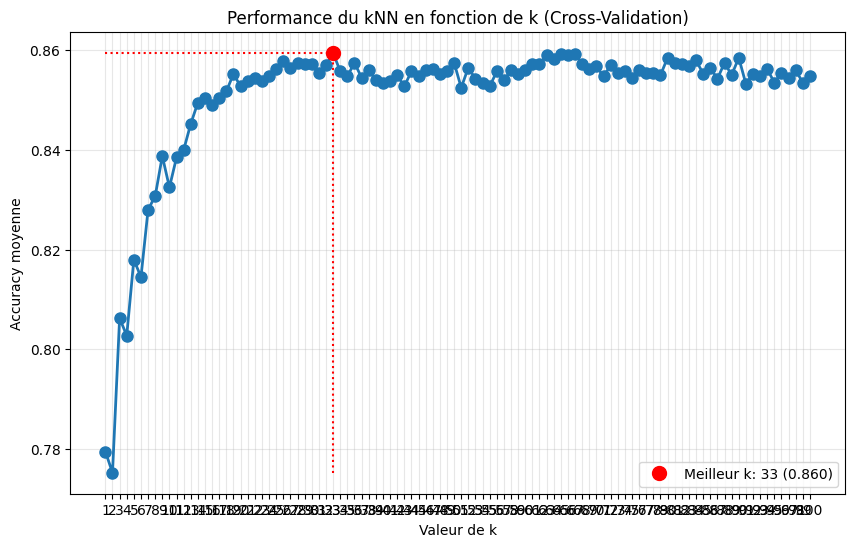

Accuracy finale sur le test set: 0.8450 (84.50%) avec k k=33
Bayes optimal: 86%


(33,
 0.8595,
 {1: 0.7795000000000001,
  2: 0.77525,
  3: 0.80625,
  4: 0.80275,
  5: 0.818,
  6: 0.8145,
  7: 0.8280000000000001,
  8: 0.8307500000000001,
  9: 0.8387499999999999,
  10: 0.8325000000000001,
  11: 0.8385,
  12: 0.8400000000000001,
  13: 0.8452500000000001,
  14: 0.8494999999999999,
  15: 0.8505,
  16: 0.849,
  17: 0.8505,
  18: 0.85175,
  19: 0.8552500000000001,
  20: 0.85275,
  21: 0.85375,
  22: 0.8545,
  23: 0.85375,
  24: 0.8547499999999999,
  25: 0.85625,
  26: 0.85775,
  27: 0.8564999999999999,
  28: 0.8574999999999999,
  29: 0.85725,
  30: 0.85725,
  31: 0.8554999999999999,
  32: 0.857,
  33: 0.8595,
  34: 0.8557500000000001,
  35: 0.8547499999999999,
  36: 0.8574999999999999,
  37: 0.8545,
  38: 0.8560000000000001,
  39: 0.8539999999999999,
  40: 0.8535,
  41: 0.85375,
  42: 0.8550000000000001,
  43: 0.85275,
  44: 0.8557500000000001,
  45: 0.8547500000000001,
  46: 0.8560000000000001,
  47: 0.85625,
  48: 0.8552500000000001,
  49: 0.8557500000000001,
  50: 0.85

In [26]:
main_knn_exp(X_np_train, y_np_train, X_np_test, y_np_test, aff=True)

Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 1, précision de 0.9522


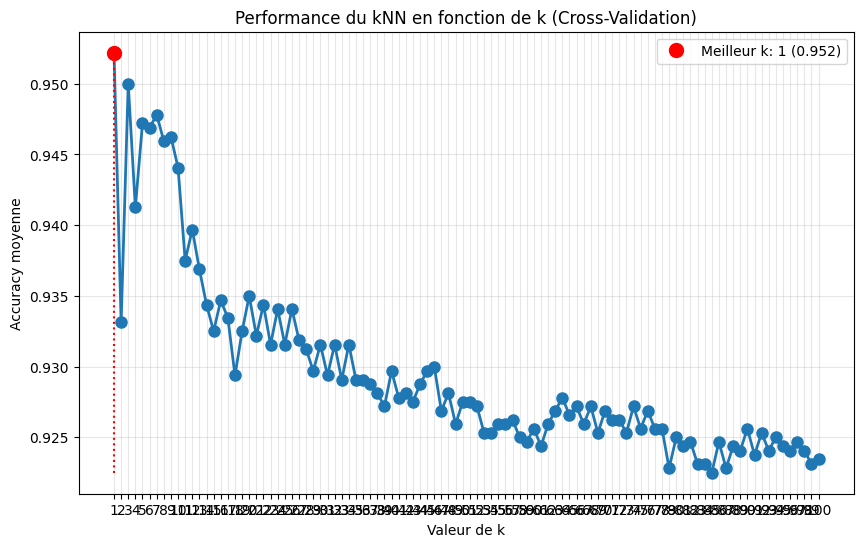

Accuracy finale sur le test set: 0.8160 (81.60%) avec k k=1
Bayes optimal: 86%


(1,
 np.float64(0.9521875),
 {1: np.float64(0.9521875),
  2: np.float64(0.9331250000000001),
  3: np.float64(0.95),
  4: np.float64(0.9412499999999999),
  5: np.float64(0.9471875000000001),
  6: np.float64(0.946875),
  7: np.float64(0.9478125000000001),
  8: np.float64(0.9459375),
  9: np.float64(0.94625),
  10: np.float64(0.9440625),
  11: np.float64(0.9375),
  12: np.float64(0.9396875),
  13: np.float64(0.936875),
  14: np.float64(0.934375),
  15: np.float64(0.9325000000000001),
  16: np.float64(0.9346875000000001),
  17: np.float64(0.9334374999999999),
  18: np.float64(0.9293750000000001),
  19: np.float64(0.9324999999999999),
  20: np.float64(0.9349999999999999),
  21: np.float64(0.9321874999999998),
  22: np.float64(0.934375),
  23: np.float64(0.9315624999999998),
  24: np.float64(0.9340624999999999),
  25: np.float64(0.9315625000000001),
  26: np.float64(0.9340624999999999),
  27: np.float64(0.931875),
  28: np.float64(0.93125),
  29: np.float64(0.9296875),
  30: np.float64(0.931

In [32]:
main_knn_exp(X_train_cleaned, y_train_cleaned, X_np_test, y_np_test, aff=True)

Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 60, précision de 0.8170


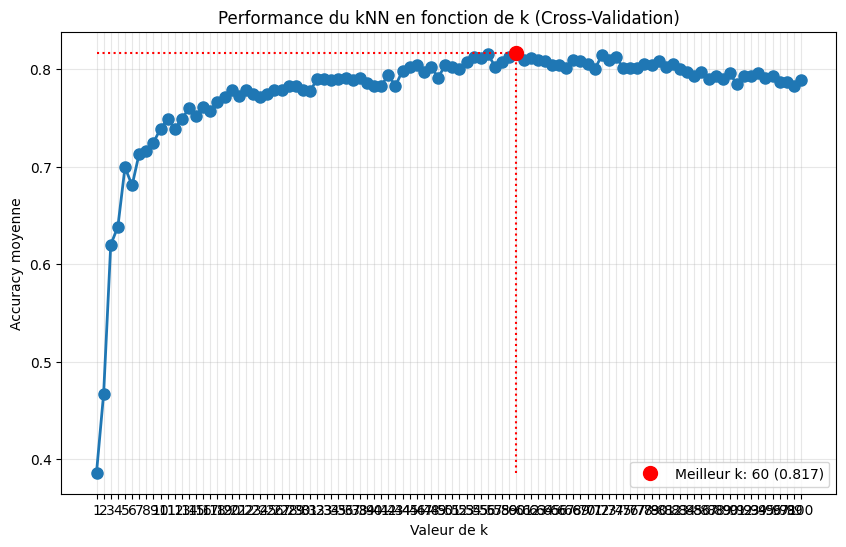

Accuracy finale sur le test set: 0.8440 (84.40%) avec k k=60
Bayes optimal: 86%


(60,
 np.float64(0.8170212765957446),
 {1: np.float64(0.38581560283687943),
  2: np.float64(0.4666666666666667),
  3: np.float64(0.6198581560283688),
  4: np.float64(0.6382978723404256),
  5: np.float64(0.699290780141844),
  6: np.float64(0.6808510638297871),
  7: np.float64(0.7134751773049646),
  8: np.float64(0.7163120567375887),
  9: np.float64(0.7248226950354609),
  10: np.float64(0.7390070921985817),
  11: np.float64(0.7489361702127659),
  12: np.float64(0.7390070921985815),
  13: np.float64(0.7489361702127659),
  14: np.float64(0.7602836879432624),
  15: np.float64(0.7517730496453899),
  16: np.float64(0.7617021276595745),
  17: np.float64(0.7574468085106383),
  18: np.float64(0.7659574468085106),
  19: np.float64(0.7716312056737589),
  20: np.float64(0.7787234042553192),
  21: np.float64(0.7730496453900709),
  22: np.float64(0.7787234042553192),
  23: np.float64(0.774468085106383),
  24: np.float64(0.7716312056737589),
  25: np.float64(0.774468085106383),
  26: np.float64(0.7787

In [34]:
main_knn_exp(X_train_cleaned2, y_train_cleaned2, X_np_test, y_np_test, aff=True)

In [27]:

data_depart = np.concatenate((X_np_train, y_np_train.reshape(-1, 1)), axis=1)
data_reduction1 = np.concatenate((X_train_cleaned, y_train_cleaned.reshape(-1, 1)), axis=1)
data_reduction2 = np.concatenate((X_train_cleaned2, y_train_cleaned2.reshape(-1, 1)), axis=1)


NameError: name 'X_train_cleaned' is not defined

In [28]:

exp_best_k = [[], [], []]
exp_best_accuracy = [[], [], []]
exp_mean_accuracies = [[], [], []]
exp_final_accuracy = [[], [], []]
exp_temps = [[], [], []]
exp_seed = [99]

In [29]:
nb_exp = 50

for n in range(nb_exp):
    print("N =", n+1, "/", nb_exp)

    exp_seed.append(exp_seed[-1] + 1)
    dataset_shuffle_exp = dataset.sample(frac=1.0, random_state=(exp_seed[-1]))

    dataset_np = dataset_shuffle_exp.to_numpy()
    X_exp_np = dataset_np[:, :-1]
    y_exp_np = dataset_np[:, -1]

    exp_X_np_test = X_exp_np[4000:, :]
    exp_y_np_test = y_exp_np[4000:]

    num = 0
    exp_X = X_exp_np[:4000, :]
    exp_y = y_exp_np[:4000]
    debut = time.time()
    best_k, best_accuracy, mean_accuracies, final_accuracy = main_knn_exp(exp_X, exp_y, exp_X_np_test, exp_y_np_test)
    fin = time.time()
    exp_best_k[num].append(best_k)
    exp_best_accuracy[num].append(best_accuracy)
    exp_mean_accuracies[num].append(mean_accuracies)
    exp_final_accuracy[num].append(final_accuracy)
    exp_temps[num].append(fin - debut)
    
    num = 1
    (exp_X, exp_y) = reduction1(exp_X, exp_y)
    debut = time.time()
    best_k, best_accuracy, mean_accuracies, final_accuracy = main_knn_exp(exp_X, exp_y, exp_X_np_test, exp_y_np_test)
    fin = time.time()
    exp_best_k[num].append(best_k)
    exp_best_accuracy[num].append(best_accuracy)
    exp_mean_accuracies[num].append(mean_accuracies)
    exp_final_accuracy[num].append(final_accuracy)
    exp_temps[num].append(fin - debut)
    
    num = 2
    (exp_X, exp_y) = reduction2(exp_X, exp_y)
    debut = time.time()
    best_k, best_accuracy, mean_accuracies, final_accuracy = main_knn_exp(exp_X, exp_y, exp_X_np_test, exp_y_np_test)
    fin = time.time()
    exp_best_k[num].append(best_k)
    exp_best_accuracy[num].append(best_accuracy)
    exp_mean_accuracies[num].append(mean_accuracies)
    exp_final_accuracy[num].append(final_accuracy)
    exp_temps[num].append(fin - debut)

print("FIN")


N = 1 / 50
Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
fold 1/5...


KeyboardInterrupt: 

In [30]:
print(len(exp_best_accuracy[0]))
print(len(exp_best_k[0]))
print(len(exp_final_accuracy[0]))
print(len(exp_mean_accuracies[0]))
print(len(exp_temps[0]))

print(exp_seed)
print(len(exp_seed))


0
0
0
0
0
[99, 100]
2


/Users/kimwilde/Library/Python/3.11/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kimwilde/Library/Python/3.11/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


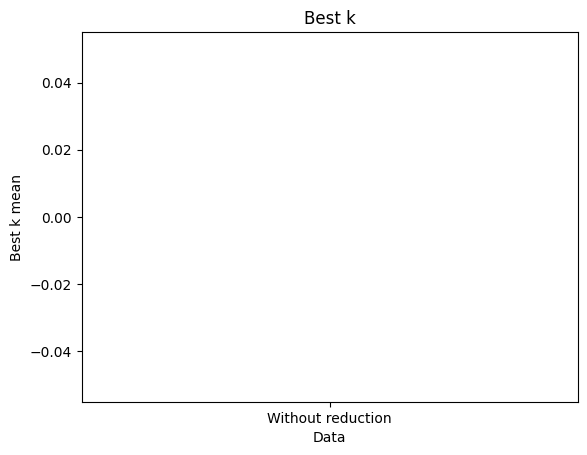

ValueError: Axis limits cannot be NaN or Inf

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


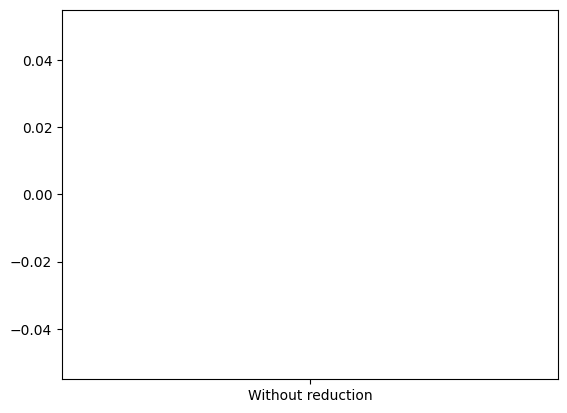

In [31]:
labels = ['Without reduction', 'Reduction 1', 'Reduction 1 + 2']

valeurs = [np.mean(np.array(exp_best_k[0])), np.mean(np.array(exp_best_k[1])), np.mean(np.array(exp_best_k[2]))]
plt.bar(labels, valeurs, color='skyblue', edgecolor='black')

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.05, f"{valeur:.2f}", ha='center', va='bottom')

plt.title("Best k")
plt.xlabel("Data")
plt.ylabel("Best k mean")

plt.show()

valeurs = [np.mean(np.array(exp_final_accuracy[0])), np.mean(np.array(exp_final_accuracy[1])), np.mean(np.array(exp_final_accuracy[2]))]
plt.bar(labels, valeurs)

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.001, f"{valeur:.2f}", ha='center', va='bottom')

y_max = max(valeurs)
plt.ylim(0, y_max + 0.05)

plt.title("Final accuracy (test time)")
plt.xlabel("Data")
plt.ylabel("Final accuracy mean")

plt.show()

valeurs = [np.mean(np.array(exp_best_accuracy[0])), np.mean(np.array(exp_best_accuracy[1])), np.mean(np.array(exp_best_accuracy[2]))]
plt.bar(labels, valeurs, edgecolor='black')

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.001, f"{valeur:.2f}", ha='center', va='bottom')

plt.title("Best accuracy (train time)")
plt.xlabel("Data")
plt.ylabel("Best accuracy mean")

plt.show()


labels = ['Without reduction', 'Reduction 1', 'Reduction 1 + 2'] 

valeurs = [np.mean(np.array(exp_temps[0])), np.mean(np.array(exp_temps[1])), np.mean(np.array(exp_temps[2]))]
plt.bar(labels, valeurs, color='green', edgecolor='black')

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.05, f"{valeur:.2f}", ha='center', va='bottom')

plt.xlabel("Data")
plt.ylabel("Time (s)")

plt.show()

### Calcul du temps d'exécution

In [18]:
exp_temps = [[], [], []]

nb_exp = 10

for n in range(nb_exp):
    print("N =", n+1, "/", nb_exp)

    num = 0
    exp_data = data_depart.copy()
    np.random.shuffle(exp_data)
    exp_X = exp_data[:, :-1]
    exp_y = exp_data[:, -1]
    debut = time.time()
    main_knn_exp(exp_X, exp_y)
    fin = time.time()
    exp_temps[num].append(fin - debut)
    
    num = 1
    exp_data = data_reduction1.copy()
    np.random.shuffle(exp_data)
    exp_X = exp_data[:, :-1]
    exp_y = exp_data[:, -1]
    debut = time.time()
    main_knn_exp(exp_X, exp_y)
    fin = time.time()
    exp_temps[num].append(fin - debut)
    
    num = 2
    exp_data = data_reduction2.copy()
    np.random.shuffle(exp_data)
    exp_X = exp_data[:, :-1]
    exp_y = exp_data[:, -1]
    debut = time.time()
    main_knn_exp(exp_X, exp_y)
    fin = time.time()
    exp_temps[num].append(fin - debut)

print("FIN")


N = 1 / 10
Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

 Meilleur k: 72, précision de 0.8575
Accuracy finale sur le test set: 0.8740 (87.40%) avec k k=72
Bayes optimal: 86%
Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 

In [1]:
labels = ['Without reduction', 'Reduction 1', 'Reduction 1 + 2'] 

valeurs = [np.mean(np.array(exp_temps[0])), np.mean(np.array(exp_temps[1])), np.mean(np.array(exp_temps[2]))]
plt.bar(labels, valeurs, color='green', edgecolor='black')

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.05, f"{valeur:.2f}", ha='center', va='bottom')

plt.xlabel("Data")
plt.ylabel("Time (s)")

plt.show()

NameError: name 'np' is not defined

### Test kNN

In [32]:
exp2_best_k = [[], [], []]
exp2_best_accuracy = [[], [], []]
exp2_mean_accuracies = [[], [], []]
exp2_final_accuracy = [[], [], []]
exp2_temps = [[], [], []]
exp2_seed = [99]

In [19]:
nb_exp = 4

for n in range(nb_exp):
    print("N =", n+1, "/", nb_exp)

    exp2_seed.append(exp2_seed[-1] + 1)
    dataset_shuffle_exp = dataset.sample(frac=1.0, random_state=(exp2_seed[-1]))

    dataset_np = dataset_shuffle_exp.to_numpy()
    X_exp_np = dataset_np[:, :-1]
    y_exp_np = dataset_np[:, -1]

    exp_X_np_test = X_exp_np[4000:, :]
    exp_y_np_test = y_exp_np[4000:]

    num = 0
    exp_X = X_exp_np[:4000, :]
    exp_y = y_exp_np[:4000]
    debut = time.time()
    best_k, best_accuracy, mean_accuracies, final_accuracy = main_knn_exp(exp_X, exp_y, exp_X_np_test, exp_y_np_test)
    fin = time.time()
    exp2_best_k[num].append(best_k)
    exp2_best_accuracy[num].append(best_accuracy)
    exp2_mean_accuracies[num].append(mean_accuracies)
    exp2_final_accuracy[num].append(final_accuracy)
    exp2_temps[num].append(fin - debut)
    

print("FIN")


N = 1 / 4


NameError: name 'main_knn_exp' is not defined

In [17]:
print((exp2_best_accuracy[0]))
print((exp2_best_k[0]))
print((exp2_final_accuracy[0]))
print(len(exp2_mean_accuracies[0]))
print((exp2_temps[0]))

#print(exp2_temps[0])
#print(exp2_best_k[0])
print(exp2_seed)
print(len(exp2_seed))

NameError: name 'exp2_best_accuracy' is not defined

In [100]:
print("best k =", np.mean(np.array(exp2_best_k[0])))
print("final accuracy =", np.mean(np.array(exp2_final_accuracy[0])))
print("best accuracy =", np.mean(np.array(exp2_best_accuracy[0])))
print("temps =", np.mean(np.array(exp2_temps[0])))

best k = 70.5
final accuracy = 0.8594599999999999
best accuracy = 0.85828
temps = 152.74824287414552


## Inégalitée triangulaire

In [155]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


def knn_algorithm_triangle_inequality(point_test, k, metrique, X_train, y_train, D_precalc=None):
    """
    KNN avec optimisation par inégalité triangulaire
    
    Args:
        point_test: point à classifier (array)
        k: nombre de voisins
        metrique: métrique de distance
        X_train: données d'entraînement (array numpy)
        y_train: labels d'entraînement (array numpy)
        D_precalc: matrice de distances précalculée (optionnel)
    """
    # Convertir en numpy array si nécessaire
    x_2d = np.array(point_test).reshape(1, -1)
    X_train_np = np.array(X_train)
    y_train_np = np.array(y_train)
    
    # Calcul des distances du point test à tous les points d'entraînement
    distances = cdist(x_2d, X_train_np, metric=metrique)[0]
    
    # Tri des indices par distance croissante
    sorted_indices = np.argsort(distances)
    
    # Initialisation: X' = premier voisin le plus proche
    first_idx = sorted_indices[0]
    d_min = distances[first_idx]
    
    # Liste pour stocker les k plus proches voisins
    k_nearest_indices = [first_idx]
    k_nearest_distances = [d_min]
    
    # Compter les points éliminés pour statistiques
    eliminated_count = 0
    
    # Parcourir les autres points dans l'ordre croissant de distance
    for idx in sorted_indices[1:]:
        # Si on a déjà k voisins et que la distance actuelle 
        # est supérieure à la k-ième distance, on peut s'arrêter
        if len(k_nearest_indices) >= k:
            if distances[idx] > max(k_nearest_distances):
                break
        
        d_X_Xi = distances[idx]
        
        # Vérifier si on peut éliminer ce point avec l'inégalité triangulaire
        can_eliminate = False
        
        if d_X_Xi > d_min:
            # Calcul de d(X', Xi) où X' est le voisin le plus proche actuel
            X_prime_idx = k_nearest_indices[0]
            d_Xprime_Xi = cdist(
                X_train_np[X_prime_idx].reshape(1, -1),
                X_train_np[idx].reshape(1, -1),
                metric=metrique
            )[0][0]
            
            # Si Xi est dans la sphère centrée en X' de rayon d(X,Xi) - d_min
            if d_Xprime_Xi + d_min <= d_X_Xi:
                can_eliminate = True
                eliminated_count += 1
        
        if not can_eliminate:
            k_nearest_indices.append(idx)
            k_nearest_distances.append(d_X_Xi)
            
            # Mettre à jour d_min si on a trouvé un voisin plus proche
            if d_X_Xi < d_min:
                d_min = d_X_Xi
                # Réorganiser pour que le plus proche soit toujours en premier
                k_nearest_indices[0], k_nearest_indices[-1] = k_nearest_indices[-1], k_nearest_indices[0]
                k_nearest_distances[0], k_nearest_distances[-1] = k_nearest_distances[-1], k_nearest_distances[0]
    
    # Garder seulement les k plus proches
    if len(k_nearest_indices) > k:
        sorted_k = np.argsort(k_nearest_distances)[:k]
        k_nearest_indices = [k_nearest_indices[i] for i in sorted_k]
    
    # Vote majoritaire
    votes = {}
    for idx in k_nearest_indices:
        label = y_train_np[idx]
        votes[label] = votes.get(label, 0) + 1
    
    return max(votes, key=votes.get)


def evaluer_modele_triangle_inequality(X_test, y_test, k, metrique, X_train, y_train):
    """
    Évalue la performance du modèle kNN avec optimisation par inégalité triangulaire
    Compatible avec numpy arrays et pandas DataFrames
    """
    # Conversion en numpy arrays
    X_test_np = np.array(X_test)
    y_test_np = np.array(y_test)
    X_train_np = np.array(X_train)
    y_train_np = np.array(y_train)
    
    nombre_correct = 0
    total = len(X_test_np)
    
    for i in range(total):
        point_test = X_test_np[i]
        vrai_label = y_test_np[i]
        
        prediction = knn_algorithm_triangle_inequality(point_test, k, metrique, X_train_np, y_train_np)
        
        if prediction == vrai_label:
            nombre_correct += 1
    
    return nombre_correct / total


def cross_validation_knn_triangle_inequality(X, y, k_values, n_folds=5, metric='euclidean'):
    """
    Cross-validation pour choisir le meilleur k avec inégalité triangulaire
    Compatible avec numpy arrays et pandas DataFrames
    
    Args:
        X: Features du dataset (numpy array ou DataFrame)
        y: Labels du dataset (numpy array ou Series)
        k_values: Liste contenant les valeurs de k à tester
        n_folds: Nombre de folds
        metric: Métrique de distance
    
    Returns:
        best_k: Meilleure valeur de k
        best_accuracy: Meilleure précision moyenne
        mean_accuracies: Dictionnaire avec les résultats pour chaque k
    """
    # Conversion en numpy arrays
    X_np = np.array(X)
    y_np = np.array(y)
    
    results = {k: [] for k in k_values}
    
    # Création des folds
    fold_size = len(X_np) // n_folds
    indices = np.arange(len(X_np))
    
    np.random.shuffle(indices)
    
    print(f"Début de la cross-validation ({n_folds} folds) avec inégalité triangulaire pour les k: {k_values}")
    
    for fold in range(n_folds):
        print(f"fold {fold + 1}/{n_folds}...")
        
        val_start = fold * fold_size
        val_end = (fold + 1) * fold_size
        val_indices = indices[val_start:val_end]
        train_indices = np.concatenate([indices[:val_start], indices[val_end:]])
        
        # Création des datasets pour ce fold
        X_train_fold = X_np[train_indices]
        y_train_fold = y_np[train_indices]
        X_val_fold = X_np[val_indices]
        y_val_fold = y_np[val_indices]
        
        # Evaluation pour chaque valeur de k
        for k in k_values:
            accuracy = evaluer_modele_triangle_inequality(X_val_fold, y_val_fold, k, metric, X_train_fold, y_train_fold)
            results[k].append(accuracy)
    
    # Calcul des moyennes et choix du meilleur k
    best_accuracy = 0
    best_k = None
    mean_accuracies = {}
    
    for k in k_values:
        mean_accuracy = np.mean(results[k])
        mean_accuracies[k] = mean_accuracy
        if mean_accuracy > best_accuracy:
            best_accuracy = mean_accuracy
            best_k = k
    
    return best_k, best_accuracy, mean_accuracies


def plot_results_triangle(mean_accuracies):
    """Trace les résultats de la cross-validation avec inégalité triangulaire"""
    
    k_values = list(mean_accuracies.keys())
    accuracies = list(mean_accuracies.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracies, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Valeur de k')
    plt.ylabel('Accuracy moyenne')
    plt.title('Performance du kNN avec inégalité triangulaire en fonction de k (Cross-Validation)')
    plt.grid(True, alpha=0.3)
    plt.xticks(k_values)
    
    best_k = max(mean_accuracies, key=mean_accuracies.get)
    best_acc = mean_accuracies[best_k]
    min_k = min(mean_accuracies, key=mean_accuracies.get)
    min_acc = mean_accuracies[min_k]
    plt.plot(best_k, best_acc, 'ro', markersize=10, label=f'Meilleur k: {best_k} ({best_acc:.3f})')
    plt.plot([k_values[0], best_k], [best_acc, best_acc], "r:")
    plt.plot([best_k, best_k], [min_acc, best_acc], "r:")
    plt.legend()
    
    plt.show()


def main_knn_triangle_inequality(X_train, y_train, X_test, y_test):
    """
    Fonction principale compatible avec numpy arrays et pandas DataFrames
    """
    # Utilise seulement les points d'entraînement pour la CV
    k_values = list(range(1, 51))
    
    best_k, best_accuracy, mean_accuracies = cross_validation_knn_triangle_inequality(
        X_train, y_train, k_values, n_folds=5, metric='euclidean'
    )
    
    print(f"\nMeilleur k: {best_k}, précision de {best_accuracy:.4f}")
    
    plot_results_triangle(mean_accuracies)
    
    # Test set avec le meilleur k
    final_accuracy = evaluer_modele_triangle_inequality(X_test, y_test, best_k, 'euclidean', X_train, y_train)
    print(f"Accuracy finale sur le test set: {final_accuracy:.4f} ({final_accuracy*100:.2f}%) avec k={best_k}")
    print(f"Bayes optimal: 86%")
    
    return best_k, best_accuracy, mean_accuracies, final_accuracy

Début de la cross-validation (5 folds) avec inégalité triangulaire pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

Meilleur k: 41, précision de 0.7973


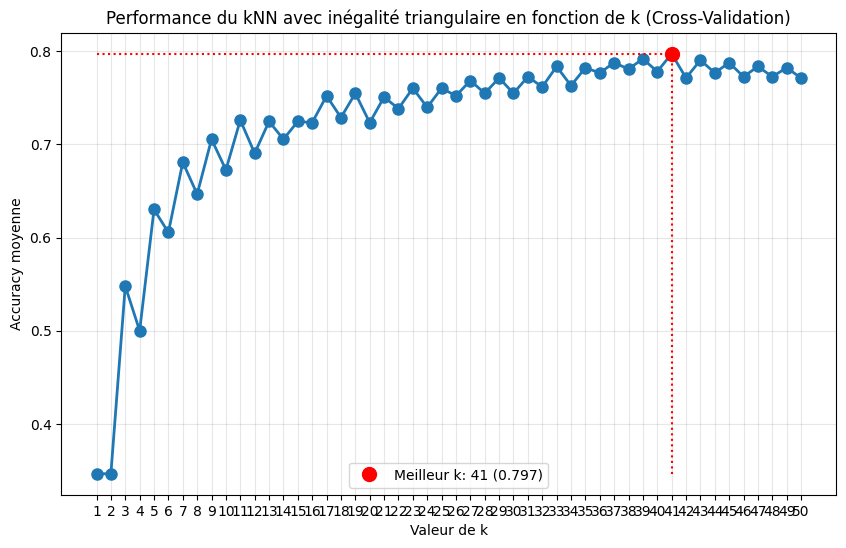

Accuracy finale sur le test set: 0.8087 (80.87%) avec k=41
Bayes optimal: 86%


In [ ]:
best_k, best_accuracy, mean_accuracies, final_accuracy = main_knn_triangle_inequality(X_train, y_train, X_test, y_test)

## kd-tree

In [153]:
from collections import Counter, defaultdict
from heapq import heappush, heappop
from random import shuffle

# Noeud du kd-tree 
class KDNode:
    def __init__(self, point, label, left=None, right=None, axis=0):
        self.point = point
        self.label = label
        self.left = left
        self.right = right
        self.axis = axis


def construire_kdtree(points, prof=0):
    """
    Construction optimisée du kd-tree 
    """
    if not points:
        return None
    k = len(points[0][0])
    axis = prof % k
    points.sort(key=lambda x: x[0][axis])
    milieu = len(points) // 2
    return KDNode(
        point=points[milieu][0],
        label=points[milieu][1],
        left=construire_kdtree(points[:milieu], prof + 1),
        right=construire_kdtree(points[milieu + 1:], prof + 1),
        axis=axis
    )
 
def distance_carre(p1, p2):
    """
    Distance euclidienne au carré entre p1 et p2
    """
    return sum((a - b) ** 2 for a, b in zip(p1, p2))
 
def knn_recherche(racine, target, k):
    """
    Recherche k-NN optimisée dans le kd-tree
    """
    heap = []

    def rec_recherche(node):
        if node is None:
            return

        dist2 = distance_carre(target, node.point)
        heappush(heap, (-dist2, node.label))
        if len(heap) > k:
            heappop(heap)

        axis = node.axis
        diff = target[axis] - node.point[axis]

        close_branch = node.left if diff < 0 else node.right
        far_branch = node.right if diff < 0 else node.left

        rec_recherche(close_branch)

        if len(heap) < k or diff ** 2 < -heap[0][0]:
            rec_recherche(far_branch)

    rec_recherche(racine)
    return [label for _, label in sorted(heap, reverse=True)]
 
def prediction_kdtree(tree, point, k=3):
    """
    Prédiction par vote majoritaire
    """
    neighbors = knn_recherche(tree, point, k)
    vote = Counter(neighbors)
    return vote.most_common(1)[0][0]


def plot_k_accuracy(k_to_avg_accuracy):
    """
    Affichage du graphe précision vs k
    """
    ks = sorted(k_to_avg_accuracy.keys())
    accs = [k_to_avg_accuracy[k] for k in ks]

    plt.figure(figsize=(8, 5))
    plt.plot(ks, accs, marker='o', linestyle='-', color='teal')
    plt.title("Précision moyenne vs k (k-NN avec kd-tree)")
    plt.xlabel("k (nombre de voisins)")
    plt.ylabel("Précision moyenne")
    plt.grid(True)
    plt.xticks(ks)
    plt.ylim(0, 1)
    plt.show()


In [147]:
def kdtree_cross_validation_knn(X, y, k_values, n_splits=5):
    X = list(X)
    y = list(y)

    class_indices = defaultdict(list)
    for i, label in enumerate(y):
        class_indices[label].append(i)

    folds = [[] for _ in range(n_splits)]
    for label, indices in class_indices.items():
        shuffle(indices)
        for i, idx in enumerate(indices):
            folds[i % n_splits].append(idx)

    k_to_accuracies = defaultdict(list)

    print(f"Début de la cross-validation sur {n_splits} folds\n")

    for k in k_values:
        print(f"Test de k = {k}")
        for i in range(n_splits):
            print(f"-> Fold {i+1}/{n_splits}", end=' ', flush=True)

            test_idx = folds[i]
            train_idx = [idx for j in range(n_splits) if j != i for idx in folds[j]]

            X_train = [X[j] for j in train_idx]
            y_train = [y[j] for j in train_idx]
            X_test = [X[j] for j in test_idx]
            y_test = [y[j] for j in test_idx]

            train_data = list(zip(X_train, y_train))
            kdtree = construire_kdtree(train_data)

            y_pred = [prediction_kdtree(kdtree, x_test, k=k) for x_test in X_test]
            correct = sum(1 for pred, true in zip(y_pred, y_test) if pred == true)
            accuracy = correct / len(y_test)

            print(f"Précision : {accuracy:.3f}")
            k_to_accuracies[k].append(accuracy)

        avg_acc = np.mean(k_to_accuracies[k])
        print(f"Moyenne pour k = {k} : {avg_acc:.3f}\n")

    k_to_avg_accuracy = {k: np.max(accs) for k, accs in k_to_accuracies.items()}
    best_k = max(k_to_avg_accuracy, key=k_to_avg_accuracy.get)
    best_accuracy = k_to_avg_accuracy[best_k]

    print("Résultats fin :")
    for k, acc in sorted(k_to_avg_accuracy.items()):
        print(f"  k = {k} → précision moyenne : {acc:.3f}")

    print(f"\nMeilleur k trouvé : {best_k}\n")

    return best_k, best_accuracy, k_to_avg_accuracy


In [148]:
def main_knn_kdtree(X_train, y_train, X_test, y_test, aff=False):
    # utilise seulement les points d'entraînement pour la CV
    k_values = list(range(1, 50 + 1))
    
    best_k, best_accuracy, mean_accuracies = kdtree_cross_validation_knn(
        X_train, y_train, k_values, n_splits=5
    )
    
    print(f"\nMeilleur k: {best_k}, précision de {best_accuracy:.4f}")
    
    if aff:
        plot_results(mean_accuracies)
    
    # test set avec le meilleur k
    train_data = list(zip(X_train, y_train))
    kdtree = construire_kdtree(train_data)
    y_pred = [prediction_kdtree(kdtree, xi, k=best_k) for xi in X_test]
    correct = sum(1 for pred, true in zip(y_pred, y_test) if pred == true)
    final_accuracy = correct / len(y_test)
    print(f"Accuracy finale sur le test set: {final_accuracy:.4f} ({final_accuracy*100:.2f}%) avec k={best_k}")
    print(f"Bayes optimal: 86%")
    
    return best_k, best_accuracy, mean_accuracies, final_accuracy

In [101]:

# # Exemple d'utilisation
# k_values = [i for i in range(1, 50 + 1)]
# best_k, accuracies = kdtree_cross_validation_knn(X_cleaned2, y_cleaned2, k_values, n_splits=5)

# print("Précision moyenne pour chaque k :")
# for k, acc in accuracies.items():
#     print(f"k = {k} → {acc*100:.2f}%")

# print(f"\nMeilleur k : {best_k}")
# plot_k_accuracy(accuracies)


## Compare knn (first version), inégalité traingulaire, kdtree 

In [163]:
exp3_best_k = [[], [], []]
exp3_best_accuracy = [[], [], []]
exp3_mean_accuracies = [[], [], []]
exp3_final_accuracy = [[], [], []]
exp3_temps = [[], [], []]
exp3_seed = [99]

In [10]:
# main_knn_triangle_inequality(X_train, y_train, X_test, y_test)
# main_knn_kdtree(X_train, y_train, X_test, y_test)

N = 1 / 2
Reduction 1 ...
Reduction 2 ...
Début de la cross-validation (5 folds) pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
fold 1/5
fold 2/5
fold 3/5
fold 4/5
fold 5/5

 Meilleur k: 32, précision de 0.8103
Accuracy finale sur le test set: 0.8550 (85.50%) avec k k=32
Bayes optimal: 86%
Début de la cross-validation (5 folds) avec inégalité triangulaire pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

Meilleur k: 37, précision de 0.7838


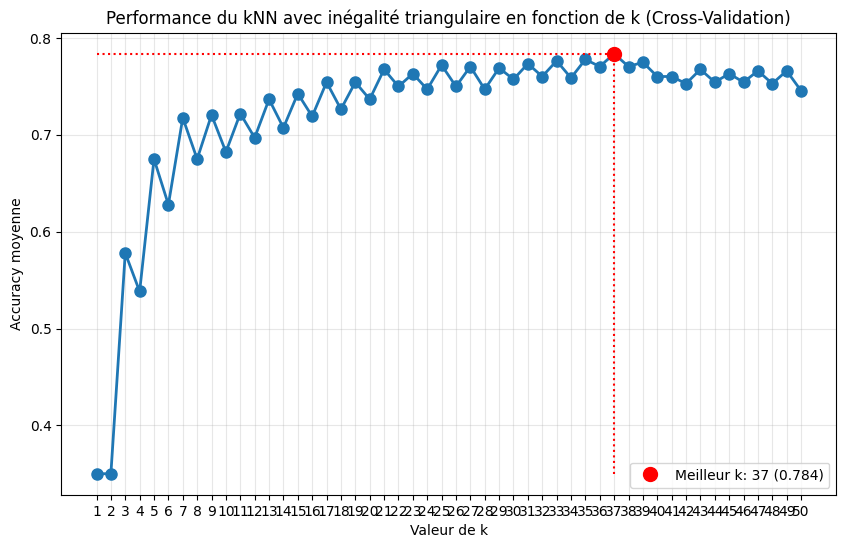

Accuracy finale sur le test set: 0.8370 (83.70%) avec k=37
Bayes optimal: 86%
Début de la cross-validation sur 5 folds

Test de k = 1
-> Fold 1/5 Précision : 0.285
-> Fold 2/5 Précision : 0.328
-> Fold 3/5 Précision : 0.287
-> Fold 4/5 Précision : 0.390
-> Fold 5/5 Précision : 0.341
Moyenne pour k = 1 : 0.326

Test de k = 2
-> Fold 1/5 Précision : 0.285
-> Fold 2/5 Précision : 0.328
-> Fold 3/5 Précision : 0.287
-> Fold 4/5 Précision : 0.390
-> Fold 5/5 Précision : 0.341
Moyenne pour k = 2 : 0.326

Test de k = 3
-> Fold 1/5 Précision : 0.518
-> Fold 2/5 Précision : 0.606
-> Fold 3/5 Précision : 0.544
-> Fold 4/5 Précision : 0.574
-> Fold 5/5 Précision : 0.570
Moyenne pour k = 3 : 0.562

Test de k = 4
-> Fold 1/5 Précision : 0.482
-> Fold 2/5 Précision : 0.489
-> Fold 3/5 Précision : 0.493
-> Fold 4/5 Précision : 0.559
-> Fold 5/5 Précision : 0.526
Moyenne pour k = 4 : 0.510

Test de k = 5
-> Fold 1/5 Précision : 0.635
-> Fold 2/5 Précision : 0.613
-> Fold 3/5 Précision : 0.603
-> Fold 

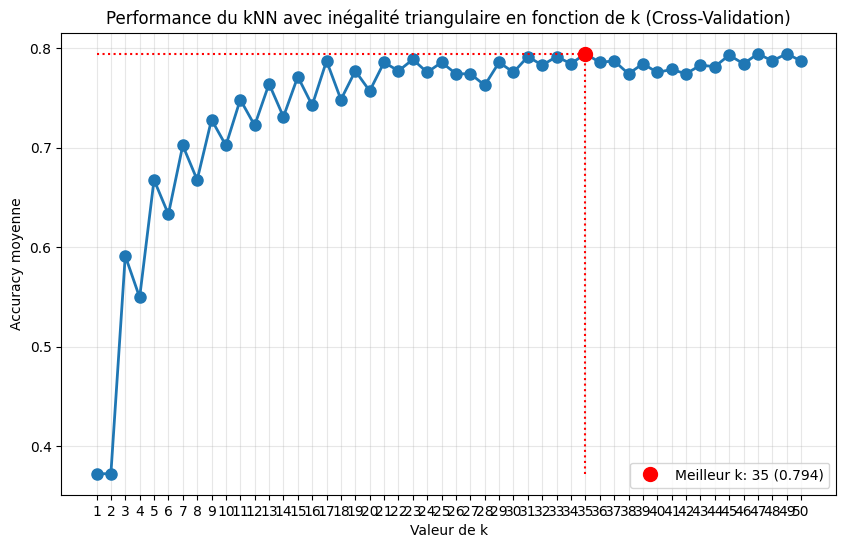

Accuracy finale sur le test set: 0.8320 (83.20%) avec k=35
Bayes optimal: 86%
Début de la cross-validation sur 5 folds

Test de k = 1
-> Fold 1/5 Précision : 0.404
-> Fold 2/5 Précision : 0.307
-> Fold 3/5 Précision : 0.338
-> Fold 4/5 Précision : 0.388
-> Fold 5/5 Précision : 0.309
Moyenne pour k = 1 : 0.349

Test de k = 2
-> Fold 1/5 Précision : 0.404
-> Fold 2/5 Précision : 0.307
-> Fold 3/5 Précision : 0.338
-> Fold 4/5 Précision : 0.388
-> Fold 5/5 Précision : 0.309
Moyenne pour k = 2 : 0.349

Test de k = 3
-> Fold 1/5 Précision : 0.574
-> Fold 2/5 Précision : 0.550
-> Fold 3/5 Précision : 0.590
-> Fold 4/5 Précision : 0.633
-> Fold 5/5 Précision : 0.604
Moyenne pour k = 3 : 0.590

Test de k = 4
-> Fold 1/5 Précision : 0.582
-> Fold 2/5 Précision : 0.529
-> Fold 3/5 Précision : 0.525
-> Fold 4/5 Précision : 0.561
-> Fold 5/5 Précision : 0.547
Moyenne pour k = 4 : 0.549

Test de k = 5
-> Fold 1/5 Précision : 0.681
-> Fold 2/5 Précision : 0.636
-> Fold 3/5 Précision : 0.619
-> Fold 

In [ ]:
nb_exp = 10

for n in range(nb_exp):
    print("N =", n+1, "/", nb_exp)

    exp3_seed.append(exp3_seed[-1] + 1)
    dataset_shuffle_exp = dataset.sample(frac=1.0, random_state=(exp3_seed[-1]))

    dataset_np = dataset_shuffle_exp.to_numpy()
    X_exp_np = dataset_np[:, :-1]
    y_exp_np = dataset_np[:, -1]

    exp_X_np_test = X_exp_np[4000:, :]
    exp_y_np_test = y_exp_np[4000:]
    
    exp_X = X_exp_np[:4000, :]
    exp_y = y_exp_np[:4000]

    print("Reduction 1 ...")
    (X_train_cleaned, y_train_cleaned) = reduction1(exp_X, exp_y) 
    print("Reduction 2 ...")
    (X_train_cleaned2, y_train_cleaned2) = reduction2(X_train_cleaned, y_train_cleaned)

    exp_X = X_train_cleaned2 
    exp_y = y_train_cleaned2

    num = 0
    debut = time.time()
    best_k, best_accuracy, mean_accuracies, final_accuracy = main_knn_exp(exp_X, exp_y, exp_X_np_test, exp_y_np_test)
    fin = time.time()
    exp3_best_k[num].append(best_k)
    exp3_best_accuracy[num].append(best_accuracy)
    exp3_mean_accuracies[num].append(mean_accuracies)
    exp3_final_accuracy[num].append(final_accuracy)
    exp3_temps[num].append(fin - debut)
    
    num = 1
    debut = time.time()
    best_k, best_accuracy, mean_accuracies, final_accuracy = main_knn_triangle_inequality(exp_X, exp_y, exp_X_np_test, exp_y_np_test)
    fin = time.time()
    exp3_best_k[num].append(best_k)
    exp3_best_accuracy[num].append(best_accuracy)
    exp3_mean_accuracies[num].append(mean_accuracies)
    exp3_final_accuracy[num].append(final_accuracy)
    exp3_temps[num].append(fin - debut)
    
    num = 2
    debut = time.time()
    best_k, best_accuracy, mean_accuracies, final_accuracy = main_knn_kdtree(exp_X, exp_y, exp_X_np_test, exp_y_np_test)
    fin = time.time()
    exp3_best_k[num].append(best_k)
    exp3_best_accuracy[num].append(best_accuracy)
    exp3_mean_accuracies[num].append(mean_accuracies)
    exp3_final_accuracy[num].append(final_accuracy)
    exp3_temps[num].append(fin - debut)

print("FIN")


In [189]:
print(len(exp3_best_accuracy[0]))
print(len(exp3_best_k[0]))
print(len(exp3_final_accuracy[0]))
print(len(exp3_mean_accuracies[0]))
print(len(exp3_temps[0]))

print(exp3_seed)
print(len(exp3_seed))

10
10
10
10
10
[99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
11


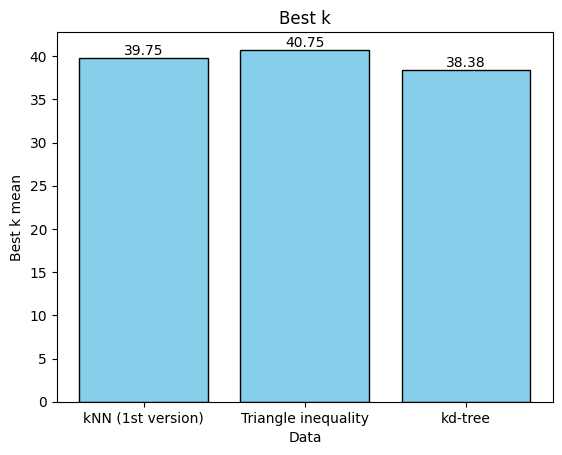

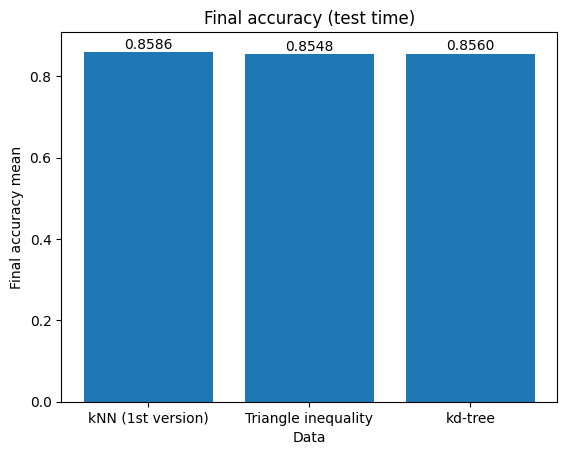

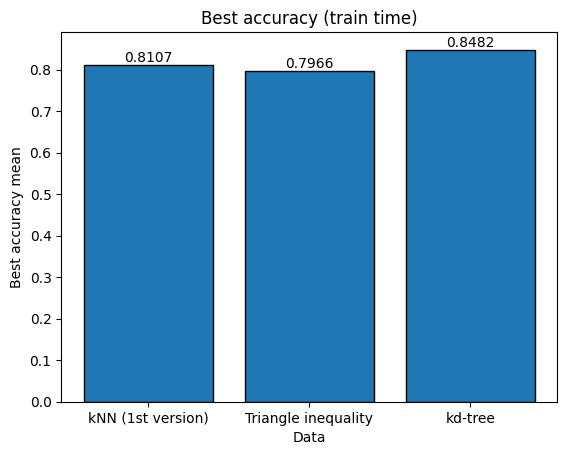

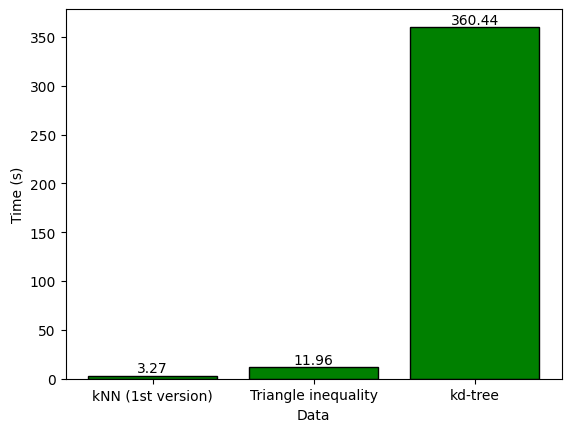

In [187]:
labels = ['kNN (1st version)', 'Triangle inequality', 'kd-tree']

valeurs = [np.mean(np.array(exp3_best_k[0])), np.mean(np.array(exp3_best_k[1])), np.mean(np.array(exp3_best_k[2]))]
plt.bar(labels, valeurs, color='skyblue', edgecolor='black')

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.05, f"{valeur:.2f}", ha='center', va='bottom')

plt.title("Best k")
plt.xlabel("Data")
plt.ylabel("Best k mean")

plt.show()

valeurs = [np.mean(np.array(exp3_final_accuracy[0])), np.mean(np.array(exp3_final_accuracy[1])), np.mean(np.array(exp3_final_accuracy[2]))]
plt.bar(labels, valeurs)

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.001, f"{valeur:.4f}", ha='center', va='bottom')

y_max = max(valeurs)
plt.ylim(0, y_max + 0.05)

plt.title("Final accuracy (test time)")
plt.xlabel("Data")
plt.ylabel("Final accuracy mean")

plt.show()

valeurs = [np.mean(np.array(exp3_best_accuracy[0])), np.mean(np.array(exp3_best_accuracy[1])), np.mean(np.array(exp3_best_accuracy[2]))]
plt.bar(labels, valeurs, edgecolor='black')

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.001, f"{valeur:.4f}", ha='center', va='bottom')

plt.title("Best accuracy (train time)")
plt.xlabel("Data")
plt.ylabel("Best accuracy mean")

plt.show()


valeurs = [np.mean(np.array(exp3_temps[0])), np.mean(np.array(exp3_temps[1])), np.mean(np.array(exp3_temps[2]))]
plt.bar(labels, valeurs, color='green', edgecolor='black')

for i, valeur in enumerate(valeurs):
    plt.text(i, valeur + 0.05, f"{valeur:.2f}", ha='center', va='bottom')

plt.xlabel("Data")
plt.ylabel("Time (s)")

plt.show()

## Compare

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix


def comparer_knn_svc(X_train, y_train, X_test, y_test, knn_function, nb_exp=5):
    """
    Compare les performances kNN avec SVC de sklearn
    
    Args:
        X_train: données d'entraînement
        y_train: labels d'entraînement
        X_test: données de test
        y_test: labels de test
        knn_function: fonction kNN (main_knn_triangle_inequality, main_knn_kdtree, etc.)
        nb_exp: nombre d'expériences à moyenner
    
    Returns:
        dictionnaire avec les résultats
    """
    
    # Initialisation des résultats
    resultats = {
        'knn': {'temps': [], 'accuracy_cv': [], 'accuracy_test': [], 
                'f1_test': [], 'precision_test': [], 'recall_test': [],
                'y_pred_test': []},
        'svc_linear': {'temps': [], 'accuracy_cv': [], 'accuracy_test': [],
                       'f1_test': [], 'precision_test': [], 'recall_test': [],
                       'y_pred_test': []},
        'svc_rbf': {'temps': [], 'accuracy_cv': [], 'accuracy_test': [],
                    'f1_test': [], 'precision_test': [], 'recall_test': [],
                    'y_pred_test': []},
        'svc_poly': {'temps': [], 'accuracy_cv': [], 'accuracy_test': [],
                     'f1_test': [], 'precision_test': [], 'recall_test': [],
                     'y_pred_test': []}
    }
    
    print("="*70)
    print("COMPARAISON kNN vs SVC")
    print("="*70)
    
    # Convertir en numpy si nécessaire
    X_train_np = np.array(X_train)
    y_train_np = np.array(y_train)
    X_test_np = np.array(X_test)
    y_test_np = np.array(y_test)
    
    for exp in range(nb_exp):
        print(f"\n--- Expérience {exp+1}/{nb_exp} ---")
        
        # 1. KNN
        print("\n1. kNN avec optimisation")
        debut = time.time()
        best_k, best_accuracy_cv, mean_accuracies, accuracy_test = knn_function(
            X_train_np, y_train_np, X_test_np, y_test_np
        )
        temps_knn = time.time() - debut
        
        # Faire prédictions kNN pour F1, Precision, Recall
        y_pred_knn = np.array([knn_algorithm_triangle_inequality(
            X_test_np[i], best_k, 'euclidean', X_train_np, y_train_np
        ) for i in range(len(X_test_np))])
        
        f1_knn = f1_score(y_test_np, y_pred_knn, average='weighted')
        precision_knn = precision_score(y_test_np, y_pred_knn, average='weighted')
        recall_knn = recall_score(y_test_np, y_pred_knn, average='weighted')
        
        resultats['knn']['temps'].append(temps_knn)
        resultats['knn']['accuracy_cv'].append(best_accuracy_cv)
        resultats['knn']['accuracy_test'].append(accuracy_test)
        resultats['knn']['f1_test'].append(f1_knn)
        resultats['knn']['precision_test'].append(precision_knn)
        resultats['knn']['recall_test'].append(recall_knn)
        resultats['knn']['y_pred_test'].append(y_pred_knn)
        
        print(f"   Time: {temps_knn:.2f}s")
        print(f"   Meilleur k: {best_k}")
        print(f"   Accuracy CV: {best_accuracy_cv:.4f}")
        print(f"   Accuracy Test: {accuracy_test:.4f}")
        print(f"   F1 Score: {f1_knn:.4f}")
        print(f"   Precision: {precision_knn:.4f}")
        print(f"   Recall: {recall_knn:.4f}")
        
        # 2. SVC LINEAR
        print("\n2. SVC avec noyau linéaire")
        debut = time.time()
        svc_linear = SVC(kernel='linear', random_state=42)
        
        cv_scores = cross_val_score(svc_linear, X_train_np, y_train_np, cv=5)
        accuracy_cv_linear = np.mean(cv_scores)
        
        svc_linear.fit(X_train_np, y_train_np)
        accuracy_test_linear = svc_linear.score(X_test_np, y_test_np)
        
        y_pred_linear = svc_linear.predict(X_test_np)
        f1_linear = f1_score(y_test_np, y_pred_linear, average='weighted')
        precision_linear = precision_score(y_test_np, y_pred_linear, average='weighted')
        recall_linear = recall_score(y_test_np, y_pred_linear, average='weighted')
        
        temps_svc_linear = time.time() - debut
        
        resultats['svc_linear']['temps'].append(temps_svc_linear)
        resultats['svc_linear']['accuracy_cv'].append(accuracy_cv_linear)
        resultats['svc_linear']['accuracy_test'].append(accuracy_test_linear)
        resultats['svc_linear']['f1_test'].append(f1_linear)
        resultats['svc_linear']['precision_test'].append(precision_linear)
        resultats['svc_linear']['recall_test'].append(recall_linear)
        resultats['svc_linear']['y_pred_test'].append(y_pred_linear)
        
        print(f"   Temps: {temps_svc_linear:.2f}s")
        print(f"   Accuracy CV: {accuracy_cv_linear:.4f}")
        print(f"   Accuracy Test: {accuracy_test_linear:.4f}")
        print(f"   F1 Score: {f1_linear:.4f}")
        print(f"   Precision: {precision_linear:.4f}")
        print(f"   Recall: {recall_linear:.4f}")
        
        # 3. SVC RBF
        print("\n3. SVC avec noyau RBF")
        debut = time.time()
        svc_rbf = SVC(kernel='rbf', random_state=42)
        
        cv_scores = cross_val_score(svc_rbf, X_train_np, y_train_np, cv=5)
        accuracy_cv_rbf = np.mean(cv_scores)
        
        svc_rbf.fit(X_train_np, y_train_np)
        accuracy_test_rbf = svc_rbf.score(X_test_np, y_test_np)
        
        y_pred_rbf = svc_rbf.predict(X_test_np)
        f1_rbf = f1_score(y_test_np, y_pred_rbf, average='weighted')
        precision_rbf = precision_score(y_test_np, y_pred_rbf, average='weighted')
        recall_rbf = recall_score(y_test_np, y_pred_rbf, average='weighted')
        
        temps_svc_rbf = time.time() - debut
        
        resultats['svc_rbf']['temps'].append(temps_svc_rbf)
        resultats['svc_rbf']['accuracy_cv'].append(accuracy_cv_rbf)
        resultats['svc_rbf']['accuracy_test'].append(accuracy_test_rbf)
        resultats['svc_rbf']['f1_test'].append(f1_rbf)
        resultats['svc_rbf']['precision_test'].append(precision_rbf)
        resultats['svc_rbf']['recall_test'].append(recall_rbf)
        resultats['svc_rbf']['y_pred_test'].append(y_pred_rbf)
        
        print(f"   Temps: {temps_svc_rbf:.2f}s")
        print(f"   Accuracy CV: {accuracy_cv_rbf:.4f}")
        print(f"   Accuracy Test: {accuracy_test_rbf:.4f}")
        print(f"   F1 Score: {f1_rbf:.4f}")
        print(f"   Precision: {precision_rbf:.4f}")
        print(f"   Recall: {recall_rbf:.4f}")
        
        # 4. SVC POLYNOMIAL
        print("\n4. SVC avec noyau polynomial")
        debut = time.time()
        svc_poly = SVC(kernel='poly', degree=3, random_state=42)
        
        cv_scores = cross_val_score(svc_poly, X_train_np, y_train_np, cv=5)
        accuracy_cv_poly = np.mean(cv_scores)
        
        svc_poly.fit(X_train_np, y_train_np)
        accuracy_test_poly = svc_poly.score(X_test_np, y_test_np)
        
        y_pred_poly = svc_poly.predict(X_test_np)
        f1_poly = f1_score(y_test_np, y_pred_poly, average='weighted')
        precision_poly = precision_score(y_test_np, y_pred_poly, average='weighted')
        recall_poly = recall_score(y_test_np, y_pred_poly, average='weighted')
        
        temps_svc_poly = time.time() - debut
        
        resultats['svc_poly']['temps'].append(temps_svc_poly)
        resultats['svc_poly']['accuracy_cv'].append(accuracy_cv_poly)
        resultats['svc_poly']['accuracy_test'].append(accuracy_test_poly)
        resultats['svc_poly']['f1_test'].append(f1_poly)
        resultats['svc_poly']['precision_test'].append(precision_poly)
        resultats['svc_poly']['recall_test'].append(recall_poly)
        resultats['svc_poly']['y_pred_test'].append(y_pred_poly)
        
        print(f"   Time: {temps_svc_poly:.2f}s")
        print(f"   Accuracy CV: {accuracy_cv_poly:.4f}")
        print(f"   Accuracy Test: {accuracy_test_poly:.4f}")
        print(f"   F1 Score: {f1_poly:.4f}")
        print(f"   Precision: {precision_poly:.4f}")
        print(f"   Recall: {recall_poly:.4f}")
    
    # Calcul des moyennes
    print("\n" + "="*70)
    print("RÉSULTATS MOYENS")
    print("="*70)
    
    moyennes = {}
    for modele in resultats.keys():
        moyennes[modele] = {
            'temps_moyen': np.mean(resultats[modele]['temps']),
            'temps_std': np.std(resultats[modele]['temps']),
            'accuracy_cv_moyen': np.mean(resultats[modele]['accuracy_cv']),
            'accuracy_cv_std': np.std(resultats[modele]['accuracy_cv']),
            'accuracy_test_moyen': np.mean(resultats[modele]['accuracy_test']),
            'accuracy_test_std': np.std(resultats[modele]['accuracy_test']),
            'f1_moyen': np.mean(resultats[modele]['f1_test']),
            'f1_std': np.std(resultats[modele]['f1_test']),
            'precision_moyen': np.mean(resultats[modele]['precision_test']),
            'precision_std': np.std(resultats[modele]['precision_test']),
            'recall_moyen': np.mean(resultats[modele]['recall_test']),
            'recall_std': np.std(resultats[modele]['recall_test'])
        }
        
        print(f"\n{modele.upper().replace('_', ' ')}:")
        print(f"  Time: {moyennes[modele]['temps_moyen']:.2f}s (±{moyennes[modele]['temps_std']:.2f}s)")
        print(f"  Accuracy CV: {moyennes[modele]['accuracy_cv_moyen']:.4f} (±{moyennes[modele]['accuracy_cv_std']:.4f})")
        print(f"  Accuracy Test: {moyennes[modele]['accuracy_test_moyen']:.4f} (±{moyennes[modele]['accuracy_test_std']:.4f})")
        print(f"  F1 Score: {moyennes[modele]['f1_moyen']:.4f} (±{moyennes[modele]['f1_std']:.4f})")
        print(f"  Precision: {moyennes[modele]['precision_moyen']:.4f} (±{moyennes[modele]['precision_std']:.4f})")
        print(f"  Recall: {moyennes[modele]['recall_moyen']:.4f} (±{moyennes[modele]['recall_std']:.4f})")
    
    return resultats, moyennes


def plot_comparaison(resultats, moyennes):
    """Crée des graphiques de comparaison entre les modèles"""
    
    modeles = list(moyennes.keys())
    modeles_labels = ['kNN\n(Triangle inequality)', 'SVC\nLinear', 'SVC\nRBF', 'SVC\nPoly']
    colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
    
    # Extraire les données
    temps_moyens = [moyennes[m]['temps_moyen'] for m in modeles]
    temps_std = [moyennes[m]['temps_std'] for m in modeles]
    accuracy_cv_moyens = [moyennes[m]['accuracy_cv_moyen'] for m in modeles]
    accuracy_cv_std = [moyennes[m]['accuracy_cv_std'] for m in modeles]
    accuracy_test_moyens = [moyennes[m]['accuracy_test_moyen'] for m in modeles]
    accuracy_test_std = [moyennes[m]['accuracy_test_std'] for m in modeles]
    f1_moyens = [moyennes[m]['f1_moyen'] for m in modeles]
    f1_std = [moyennes[m]['f1_std'] for m in modeles]
    precision_moyens = [moyennes[m]['precision_moyen'] for m in modeles]
    precision_std = [moyennes[m]['precision_std'] for m in modeles]
    recall_moyens = [moyennes[m]['recall_moyen'] for m in modeles]
    recall_std = [moyennes[m]['recall_std'] for m in modeles]
    
    # Figure 1: 6 graphiques en grille
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    
    # 1. TEMPS
    ax = axes[0, 0]
    bars = ax.bar(modeles_labels, temps_moyens, yerr=temps_std, color=colors, alpha=0.7, capsize=5, edgecolor='black', linewidth=1.5)
    ax.set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
    ax.set_title('Execution Time', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    for bar, val in zip(bars, temps_moyens):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{val:.2f}s', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 2. ACCURACY CV
    ax = axes[0, 1]
    bars = ax.bar(modeles_labels, accuracy_cv_moyens, yerr=accuracy_cv_std, color=colors, alpha=0.7, capsize=5, edgecolor='black', linewidth=1.5)
    ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax.set_title('Accuracy Cross-Validation', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.axhline(y=0.86, color='red', linestyle='--', linewidth=2, alpha=0.5)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    for bar, val in zip(bars, accuracy_cv_moyens):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 3. ACCURACY TEST
    ax = axes[0, 2]
    bars = ax.bar(modeles_labels, accuracy_test_moyens, yerr=accuracy_test_std, color=colors, alpha=0.7, capsize=5, edgecolor='black', linewidth=1.5)
    ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax.set_title('Accuracy Test Set', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.axhline(y=0.86, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Bayes optimal')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.legend(fontsize=9)
    for bar, val in zip(bars, accuracy_test_moyens):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 4. F1 SCORE
    ax = axes[1, 0]
    bars = ax.bar(modeles_labels, f1_moyens, yerr=f1_std, color=colors, alpha=0.7, capsize=5, edgecolor='black', linewidth=1.5)
    ax.set_ylabel('F1 Score', fontsize=11, fontweight='bold')
    ax.set_title('F1 Score (weighted)', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    for bar, val in zip(bars, f1_moyens):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 5. PRECISION
    ax = axes[1, 1]
    bars = ax.bar(modeles_labels, precision_moyens, yerr=precision_std, color=colors, alpha=0.7, capsize=5, edgecolor='black', linewidth=1.5)
    ax.set_ylabel('Precision', fontsize=11, fontweight='bold')
    ax.set_title('Precision (weighted)', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    for bar, val in zip(bars, precision_moyens):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # 6. RECALL
    ax = axes[1, 2]
    bars = ax.bar(modeles_labels, recall_moyens, yerr=recall_std, color=colors, alpha=0.7, capsize=5, edgecolor='black', linewidth=1.5)
    ax.set_ylabel('Recall', fontsize=11, fontweight='bold')
    ax.set_title('Recall (weighted)', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    for bar, val in zip(bars, recall_moyens):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Figure 2: Scatter temps vs accuracy
    fig, ax = plt.subplots(figsize=(10, 7))
    for i, (modele, label) in enumerate(zip(modeles, modeles_labels)):
        ax.scatter(moyennes[modele]['temps_moyen'], moyennes[modele]['accuracy_test_moyen'],
                  s=300, color=colors[i], alpha=0.7, edgecolors='black', linewidth=2, label=label)
        ax.annotate(label, (moyennes[modele]['temps_moyen'], moyennes[modele]['accuracy_test_moyen']),
                   xytext=(10, 10), textcoords='offset points', fontsize=11, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor=colors[i], alpha=0.3))
    
    ax.set_xlabel('Execution Time (seconds)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Accuracy Test', fontsize=12, fontweight='bold')
    ax.set_title('Performance: Time vs Accuracy', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.axhline(y=0.86, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Bayes optimal')
    ax.legend(fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # Figure 3: Radar chart
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    categories = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'Time']
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    for i, modele in enumerate(modeles):
        temps_norm = 1 / (1 + moyennes[modele]['temps_moyen'])
        values = [moyennes[modele]['accuracy_test_moyen'], moyennes[modele]['f1_moyen'],
                 moyennes[modele]['precision_moyen'], moyennes[modele]['recall_moyen'], temps_norm]
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=modeles_labels[i], color=colors[i])
        ax.fill(angles, values, alpha=0.15, color=colors[i])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=11, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.set_title('Radar Performance Comparison', fontsize=14, fontweight='bold', pad=20)
    ax.grid(True)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # Figure 4: Tableau de synthèse
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.axis('tight')
    ax.axis('off')
    
    data = []
    for i, modele in enumerate(modeles):
        data.append([modeles_labels[i].replace('\n', ' '), f"{moyennes[modele]['temps_moyen']:.2f}s",
                    f"{moyennes[modele]['accuracy_test_moyen']:.4f}", f"{moyennes[modele]['f1_moyen']:.4f}",
                    f"{moyennes[modele]['precision_moyen']:.4f}", f"{moyennes[modele]['recall_moyen']:.4f}"])
    
    columns = ['Model', 'Time (s)', 'Accuracy', 'F1 Score', 'Precision', 'Recall']
    table = ax.table(cellText=data, colLabels=columns, cellLoc='center', loc='center', colColours=['#cccccc']*6)
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2.5)
    
    for i in range(len(columns)):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    for i in range(1, len(data) + 1):
        for j in range(len(columns)):
            table[(i, j)].set_facecolor('#E7E6E6' if i % 2 == 0 else '#F2F2F2')
    
    plt.title('Performance Synthesis', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

COMPARAISON kNN vs SVC

--- Expérience 1/1 ---

1. kNN avec optimisation
Début de la cross-validation (5 folds) avec inégalité triangulaire pour les k: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...

Meilleur k: 31, précision de 0.8553


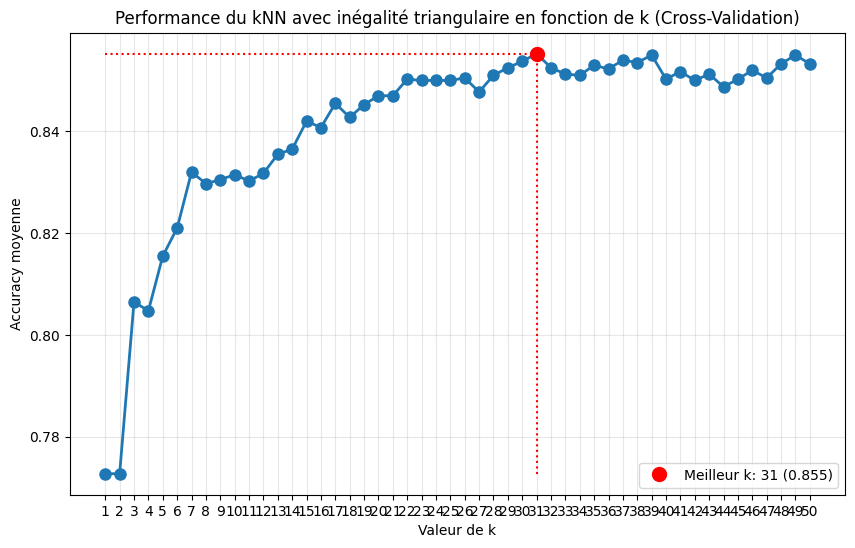

Accuracy finale sur le test set: 0.8490 (84.90%) avec k=31
Bayes optimal: 86%
   Time: 186.91s
   Meilleur k: 31
   Accuracy CV: 0.8553
   Accuracy Test: 0.8490
   F1 Score: 0.8477
   Precision: 0.8497
   Recall: 0.8490

2. SVC avec noyau linéaire
   Temps: 5.49s
   Accuracy CV: 0.8678
   Accuracy Test: 0.8610
   F1 Score: 0.8608
   Precision: 0.8608
   Recall: 0.8610

3. SVC avec noyau RBF
   Temps: 5.92s
   Accuracy CV: 0.8680
   Accuracy Test: 0.8620
   F1 Score: 0.8616
   Precision: 0.8618
   Recall: 0.8620

4. SVC avec noyau polynomial
   Time: 3.23s
   Accuracy CV: 0.8628
   Accuracy Test: 0.8520
   F1 Score: 0.8517
   Precision: 0.8517
   Recall: 0.8520

RÉSULTATS MOYENS

KNN:
  Time: 186.91s (±0.00s)
  Accuracy CV: 0.8553 (±0.0000)
  Accuracy Test: 0.8490 (±0.0000)
  F1 Score: 0.8477 (±0.0000)
  Precision: 0.8497 (±0.0000)
  Recall: 0.8490 (±0.0000)

SVC LINEAR:
  Time: 5.49s (±0.00s)
  Accuracy CV: 0.8678 (±0.0000)
  Accuracy Test: 0.8610 (±0.0000)
  F1 Score: 0.8608 (±0.0000)

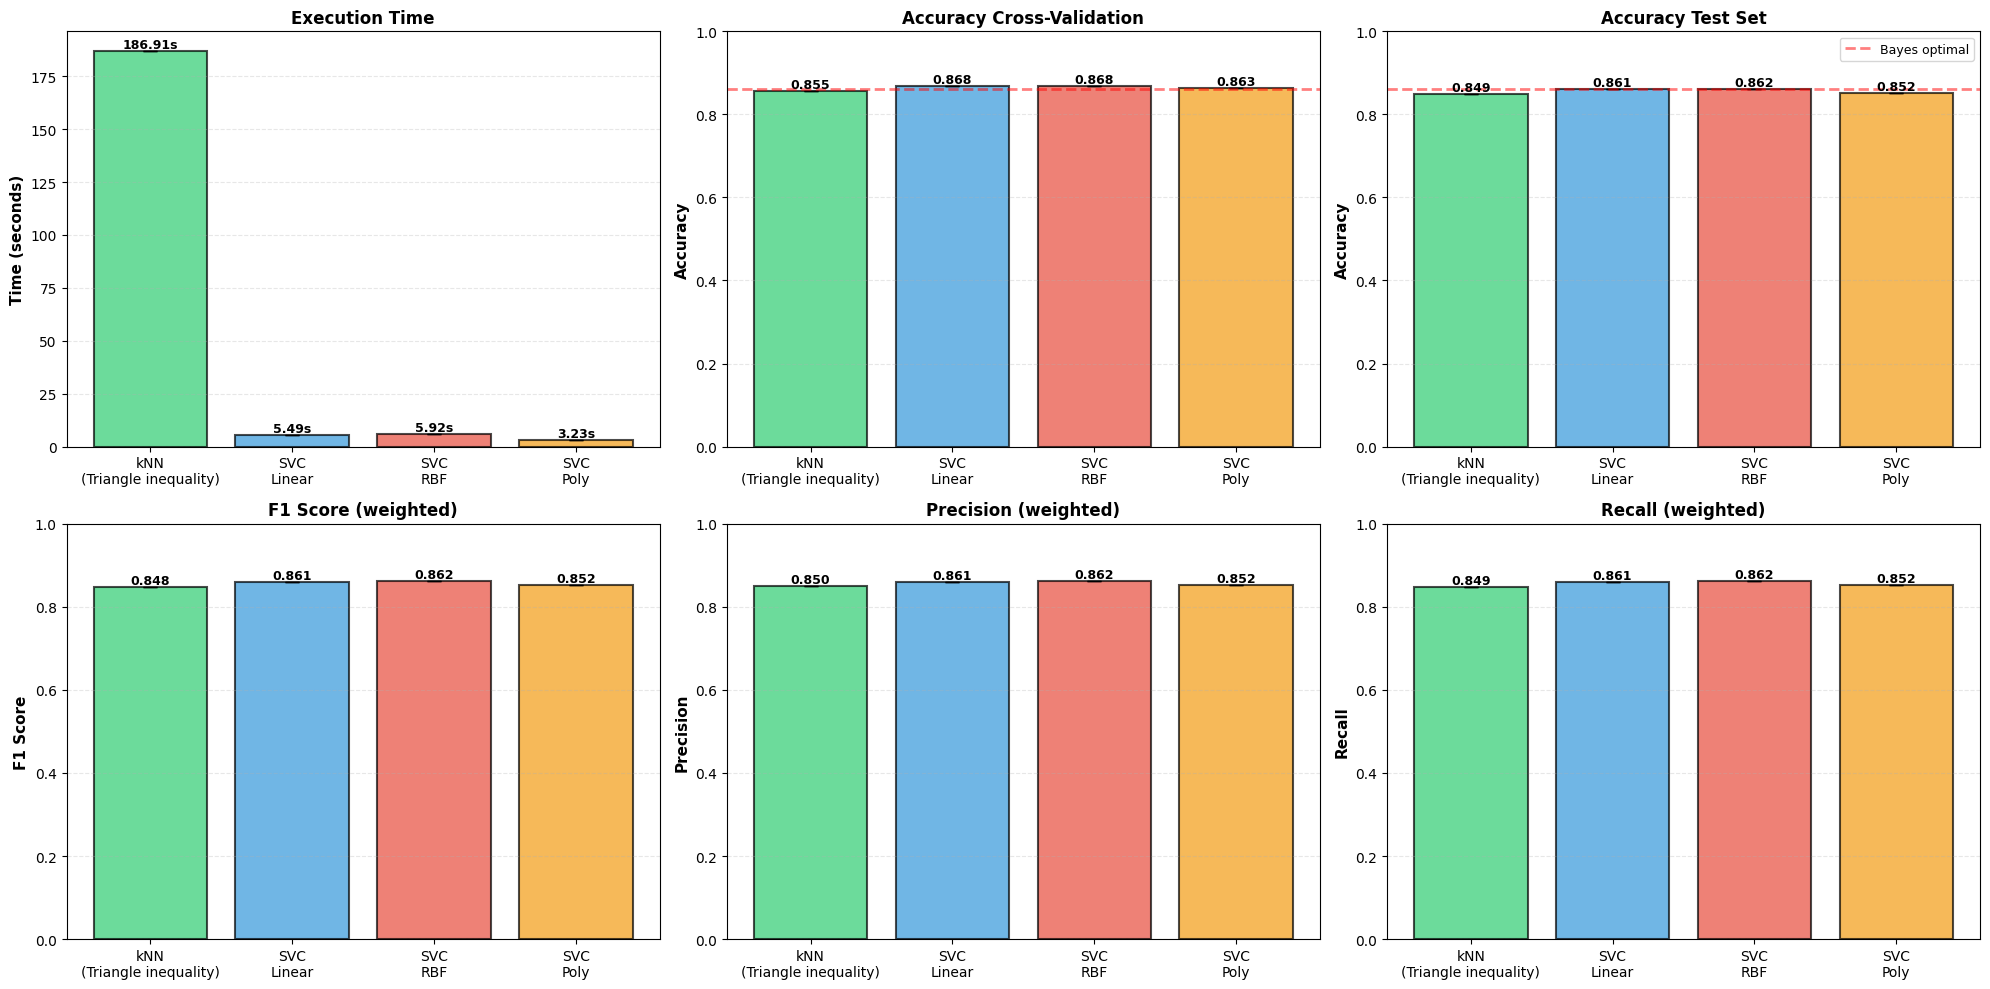

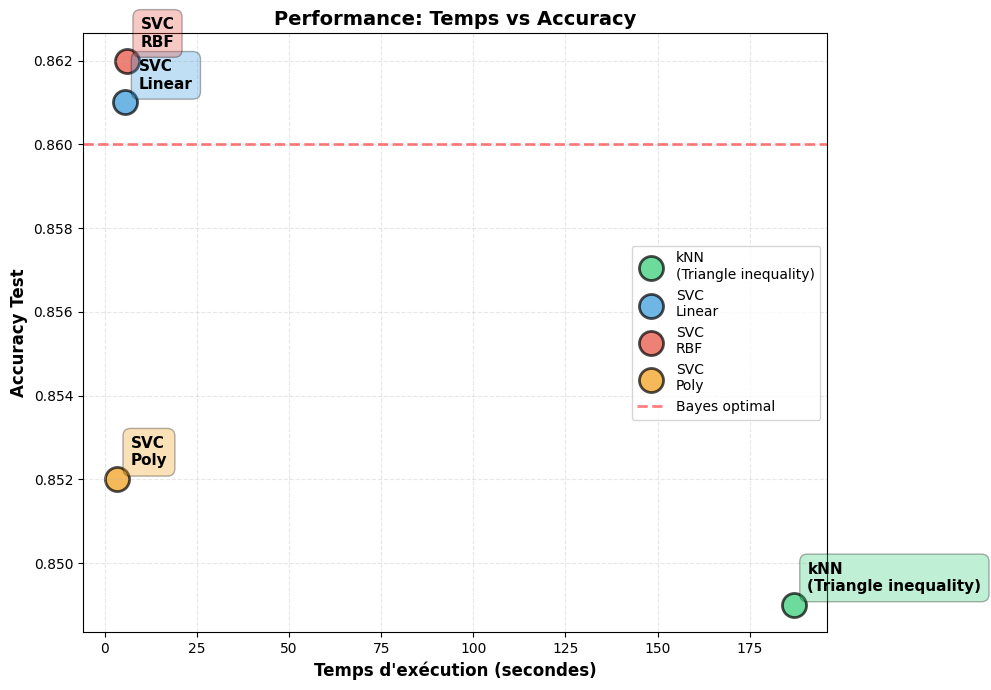

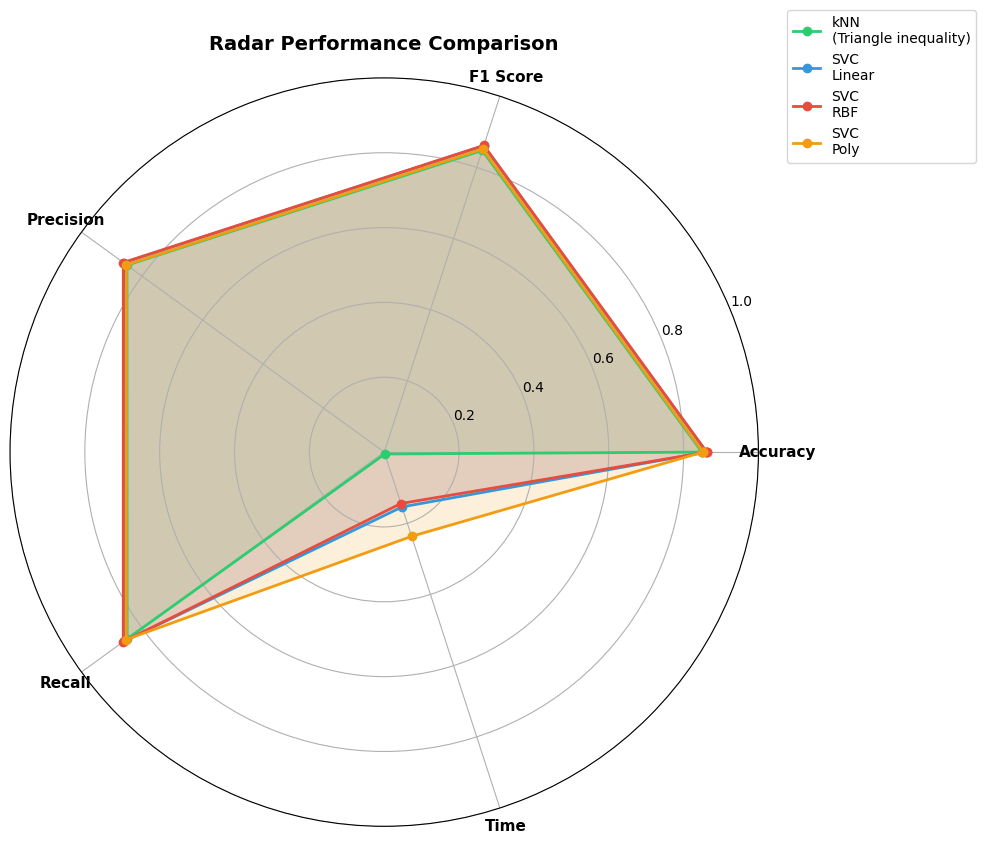

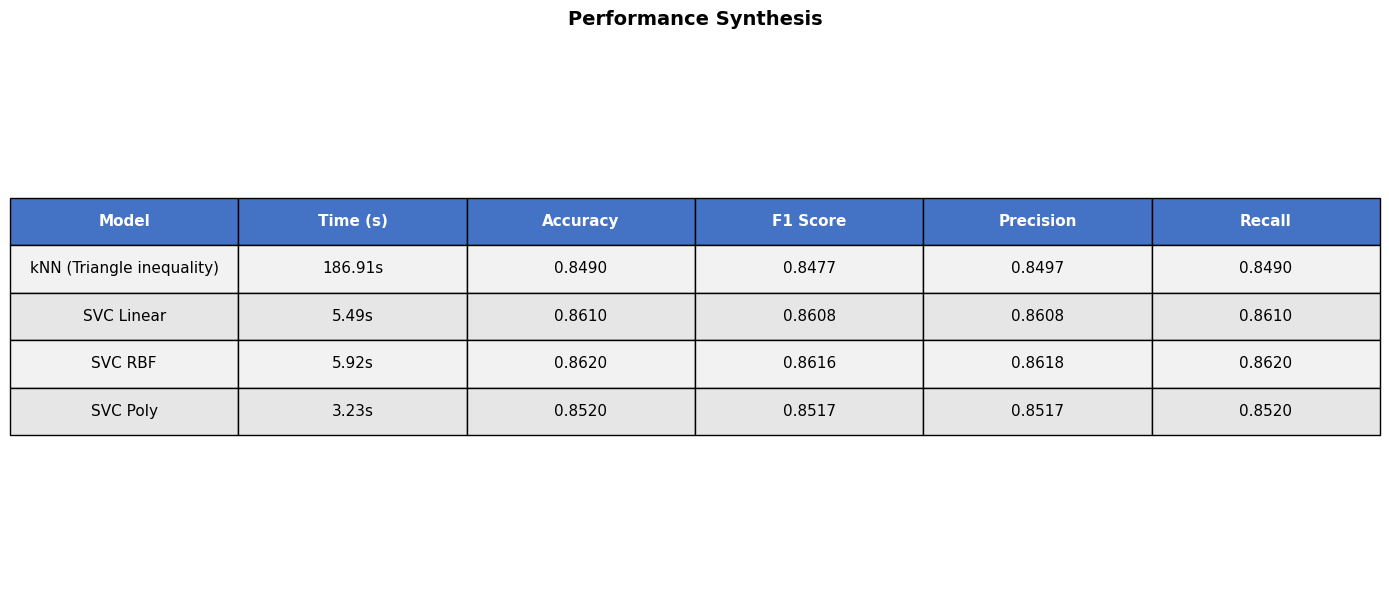

In [60]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import time
import numpy as np
import matplotlib.pyplot as plt


resultats, moyennes = comparer_knn_svc(
    X_train, y_train, X_test, y_test, 
    knn_function=main_knn_triangle_inequality,
    nb_exp=1
)

plot_comparaison(resultats, moyennes)